# Preprocessing the multimodal data for Hierarchical classification
This script is used for aggregating the multimodal data based on the Visit and forming the research-ready data for the hierarchical classification model
- 1-Extract and deduplicate non-time series data from VISIT_ZY/PERSON/P1_NOTE_STRUC/P1_NOTE_JWS/P1_NOTE_GRS/P1_MEASUREMEN_VAL/P1_MEASUREMENT_CAT/P1_SIGN_STAT, and split the data into numerical variables and categorical variables.
- 2-Merge the above data using the VISIT_ZY table as the core, and replace all missing values with ''.
- 3-Create a dictionary for non-temporal data features.
- 4-Create a dictionary for categorical variable values.
- 5-Analyzing the sampling frequency distribution of multiple time series variables within X hours
- 6-Analyzing the distribution of time intervals between the start of sampling for multiple time series variables within X hours and the admission time.
- 7-Sequential processing of time series data for each visit.
- 8-Extracting label data.
- 9-Aggregate the data by individual visit, combining non-temporal data, temporal data, and label data.
- 10-Aggregate the data by data type, using individual visit as the basic unit of storage.

In [1]:
from __future__ import print_function

import os
import re
import sys
import math
import pickle
import datetime
import itertools
import traceback
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from collections import OrderedDict
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from multiprocessing import Pool, cpu_count
from sklearn.model_selection import KFold,StratifiedKFold
from operator import itemgetter, attrgetter, methodcaller
from sqlalchemy import Table, select, text, distinct, types
from sqlalchemy.dialects.oracle import BFILE, BLOB, CHAR, CLOB, DATE, DOUBLE_PRECISION, FLOAT, INTERVAL, LONG, NCLOB, NUMBER, NVARCHAR, NVARCHAR2, RAW, TIMESTAMP, VARCHAR, VARCHAR2

from utils.utils import sparsify
from config.orcl import db_connection

%matplotlib inline

In [2]:
# set the working_path to control the different operation-version
# WORKING_PATH_V1 = './data/phase_iii'
# OUTPUT_PATH_V1 = './output/phase_iii'   # the first version of data

# WORKING_PATH_V1 = './data/phase_iv'
# OUTPUT_PATH_V1 = './output/phase_iv'    # the second version of data, which use the first 24h and last 48h data to build the model

# WORKING_PATH_V1 = './data/phase_v'
# OUTPUT_PATH_V1 = './output/phase_v'     # with the clear label where flag=1 in table label4visit

# WORKING_PATH_V1 = './data/phase_vi'       # the new data fold to contain the data in 20220106
# OUTPUT_PATH_V1 = './output/phase_vi'

# WORKING_PATH_V1 = './data/phase_vii'       # delete the SPO2 and pressure data
# OUTPUT_PATH_V1 = './output/phase_vii'

WORKING_PATH = './data/phase_viii'       # add the systolic pressure to time-series data and seperate into 48hours, 72hours, 96hours
OUTPUT_PATH = './output/phase_viii'

# connect to the database
try:
    db_conn = db_connection('fuo')
    db_conn.conn.close()
    print('[info] Connected to oracle database!')
except:
    print('[info] Failed to connect!')

# define the global param
T_LENGTH = 120 # 48, 72, 96
WORKING_PATH_V1 = os.path.join(WORKING_PATH, '{}hours'.format(T_LENGTH))
OUTPUT_PATH_V1 = os.path.join(OUTPUT_PATH, '{}hours'.format(T_LENGTH))
if not os.path.exists(WORKING_PATH_V1):
    os.makedirs(WORKING_PATH_V1)
if not os.path.exists(OUTPUT_PATH_V1):
    os.makedirs(OUTPUT_PATH_V1)


[info] Connected to oracle database!


### 1- Get the visit_id list and corresponding visit information about patient
- person: person
- visit: visit_zy
- symptom: p1_note_struc
- jws: p1_note_jws
- grs: p1_note_grs
- measurement: p1_measurement_val and p1_measurement_cat
- sign_stat: p1_sign_stat

In [3]:
def processing_visit(table_name_visit, table_name_person):
    """
    Args:
        table_name_visit: The table name of visit
        table_name_person: The table name of person
    Returns:
        basic_info: The DataFrame of merged person and visit table
    """
    db_conn = db_connection('fuo')
    visit = pd.read_sql_table(table_name_visit, db_conn.conn)
    visit = visit[['visit_record_id', 'visit_record_id_new_1', 'person_id', 'visit_start_date', 'visit_age', 'weight', 'height', 'los']]
    print("[statistics] The shape of table visit_zy is {}".format(visit.shape))
    print("[statistics] The number of unique  person_id is {}".format(len(visit['person_id'].unique())))
    print("[statistics] The number of unique  visit_record_id is {}".format(len(visit['visit_record_id'].unique())))
    print("[statistics] The number of unique  visit_record_id_new_1 is {}".format(len(visit['visit_record_id_new_1'].unique())))

    # drop duplicates
    if any(visit.duplicated(subset=['visit_record_id_new_1'])):
        visit.sort_values(by=['visit_record_id_new_1', 'visit_start_date'], na_position='last', inplace=True, ascending=True)
        visit.drop_duplicates(subset=['visit_record_id_new_1'], keep='first', inplace=True)

    # take out the visit year, month, day from the column visit_start_date
    visit['visit_year'] = visit['visit_start_date'].dt.year
    visit['visit_month'] = visit['visit_start_date'].dt.month
    visit['visit_day'] = visit['visit_start_date'].dt.day

    # exclude the visit with visit age < 15
    excluded_num_age = len(visit.loc[visit['visit_age'] <= 14])
    visit = visit.loc[visit['visit_age'] > 14]
    print("[exclude message] The number of visits excluded because of age < 15 is {}".format(excluded_num_age))

    # merge with table person to get the gender data
    person = pd.read_sql_table(table_name_person, db_conn.conn)
    person = person[['person_id', 'gender']]
    print("[statistics] The shape of table person is {}".format(person.shape))
    print("[statistics] The number of unique  person_id is {}".format(len(person['person_id'].unique())))
    if any(person.duplicated(subset=['person_id'])):
        person.sort_values(by=['person_id', 'gender'], na_position='last', inplace=True, ascending=True)
        person.drop_duplicates(subset=['person_id'], keep='first', inplace=True)

    # merge the table person and visit
    basic_info = visit.merge(person, how='left', on='person_id')
    visit_ids = basic_info['visit_record_id_new_1'].values.tolist()
    visit_ids_txt = ','.join(map(str, visit_ids))
    if not len(visit_ids) == len(set(visit_ids)):
        print('[warning] There are still duplicated visit_id!')
    else:
        print("[statistics] The unique number of visit_ids are {}".format(len(visit_ids)))

    # save the visit_ids into .npy file
    if not os.path.exists(WORKING_PATH_V1):
        os.makedirs(WORKING_PATH_V1)
    tosave = {'visit_ids': visit_ids, 'visit_ids_txt': visit_ids_txt}
    np.save(os.path.join(WORKING_PATH_V1, 'visit_ids.npy'), tosave)   # len = 33636
    db_conn.conn.close()

    return basic_info

In [4]:
def processing_symptom(table_name_symptom):
    """
    Args:
        table_name_symptom: The table name of structured symptom
    Returns:
        sytm_val: The DataFrame of continous variables
        sytm_cat: The DataFrame of category variables
    """
    db_conn = db_connection('fuo')
    sytm = pd.read_sql_table(table_name_symptom, db_conn.conn)
    if any(sytm.duplicated(subset=['visit_record_id_new_1', 'name'])):
        sytm.sort_values(by = ['visit_record_id_new_1', 'name', 'visit_record_id', 'value'], na_position = 'last', ascending=True, inplace = True)
        sytm.drop_duplicates(subset=['visit_record_id_new_1','name'], keep='first', inplace=True)

    sytm = sytm[['visit_record_id_new_1', 'name', 'value']]
    sytm_val = sytm.loc[(sytm['name'] == '发热-时长') | (sytm['name'] == '最高体温')]
    sytm_cat = sytm.loc[(sytm['name'] != '发热-时长') & (sytm['name'] != '最高体温')]
    print("[statistics] The shape of sytm is {}".format(sytm.shape))
    print("[statistics] The unique number of visit_record_id_new_1 is {}".format(len(sytm['visit_record_id_new_1'].unique())))
    print("[statistics] The unique number of name is {}".format(len(sytm['name'].unique())))

    db_conn.conn.close()
    return (sytm_val, sytm_cat)
    

In [5]:
def processing_personal_history(table_name_personal_history):
    """
    Args:
        table_name_personal_history: The table name of structured personal history
    Returns:
        grs: The DataFrame of grs variables
    """
    db_conn = db_connection('fuo')
    grs = pd.read_sql_table(table_name_personal_history, db_conn.conn)

    # drop duplicates in the range of all columns
    if any(grs.duplicated(subset=['visit_record_id_new_1', 'name'])):
        grs.sort_values(by = ['visit_record_id_new_1', 'name', 'visit_record_id', 'value'], na_position = 'last', inplace = True, ascending=True)
        grs.drop_duplicates(subset=['visit_record_id_new_1', 'name'], keep='first', inplace=True)
    grs = grs[['visit_record_id_new_1', 'name', 'value']]
    print("[statistics] The shape of grs is {}".format(grs.shape))
    print("[statistics] The unique number of visit_record_id_new_1 is {}".format(len(grs['visit_record_id_new_1'].unique())))
    print("[statistics] The unique number of name is {}".format(len(grs['name'].unique())))
    db_conn.conn.close()
    return grs

In [6]:
def processing_previous_history(table_name_previous_history):
    """
    Args:
        table_name_previous_history: The table name of structured previous history
    Returns:
        jws: The DataFrame of jws
    """
    db_conn = db_connection('fuo')
    jws = pd.read_sql_table(table_name_previous_history, db_conn.conn)
    # take specific jws data
    name_included = ['既往体质', '输血史', '外伤史', '糖尿病史', '肾病史', '肾病史', '心脏病史', '肺结核史', '高血压史', '长期用药史', '手术史']
    jws = jws[jws['name'].isin(name_included)]

    # drop duplicates in the range of all columns
    if any(jws.duplicated(subset=['visit_record_id_new_1', 'name'])):
        jws.sort_values(by = ['visit_record_id_new_1', 'name', 'visit_record_id', 'value'], na_position = 'last', inplace = True, ascending=True)
        jws.drop_duplicates(subset=['visit_record_id_new_1', 'name'], keep='first', inplace=True)

    jws = jws[['visit_record_id_new_1', 'name', 'value']]
    # generalize the value
    jws.loc[jws['value']=='否认', ['value']] = '无'
    jws.loc[jws['value']=='患', ['value']] = '无'
    jws.loc[(jws['name']=='既往体质') & (jws['value']=='良'), ['value']] = '良好'
    jws.loc[(jws['name']=='既往体质') & (jws['value']=='偏差'), ['value']] = '较差'
    jws.loc[(jws['name']=='既往体质') & (jws['value']=='好'), ['value']] = '良好'
    jws.loc[(jws['name']=='既往体质') & (jws['value']=='欠佳'), ['value']] = '较差'
    jws.loc[(jws['name']=='既往体质') & (jws['value']=='差'), ['value']] = '较差'
    jws.loc[(jws['name']=='既往体质') & (jws['value']=='可'), ['value']] = '一般'
    jws.loc[(jws['name']=='既往体质') & (jws['value']=='尚可'), ['value']] = '一般'
    jws.loc[(jws['name']=='既往体质') & (jws['value']=='体健'), ['value']] = '良好'

    print("[statistics] The shape of jws is {}".format(jws.shape))
    print("[statistics] The unique number of visit_record_id_new_1 is {}".format(len(jws['visit_record_id_new_1'].unique())))
    print("[statistics] The unique number of name is {}".format(len(jws['name'].unique())))
    db_conn.conn.close()
    return jws

In [7]:
def processing_measurement(table_name_measurement_val, table_name_measurement_cat):
    """
    Args:
        table_name_measurement_val: The table name of measurement containing continous variables
        table_name_measurement_cat: The table name of measurement containing category variables
    Returns:
        jws: The DataFrame of measurement
    """
    # get the measurement data
    db_conn = db_connection('fuo')
    mea_cat = pd.read_sql_table(table_name_measurement_cat, db_conn.conn)
    mea_val = pd.read_sql_table(table_name_measurement_val, db_conn.conn)
    # drop duplicates from measurement
    if any(mea_cat.duplicated(subset=['visit_record_id_new_1', 'specimen', 'item_name'])):
        mea_cat.sort_values(by = ['visit_record_id_new_1', 'specimen', 'item_name', 'visit_record_id_1'], na_position = 'last', ascending=True, inplace = True)
        mea_cat.drop_duplicates(subset=['visit_record_id_new_1','specimen','item_name'], keep='first', inplace=True)

    if any(mea_val.duplicated(subset=['visit_record_id_new_1', 'specimen', 'item_name'])):
        mea_val.sort_values(by = ['visit_record_id_new_1', 'specimen', 'item_name', 'visit_record_id_1'], na_position = 'last', ascending=True, inplace = True)
        mea_val.drop_duplicates(subset=['visit_record_id_new_1','specimen','item_name'], keep='first', inplace=True)

    mea_cat['name'] = mea_cat.apply(lambda x: x['specimen'] + '-' + x['item_name'], axis = 1)
    mea_val['name'] = mea_val.apply(lambda x: x['specimen'] + '-' + x['item_name'], axis = 1)
    mea_val = mea_val[['visit_record_id_new_1','name','value']]     # number
    mea_cat = mea_cat[['visit_record_id_new_1','name','value']]     # category
    print("[statistics] The shape of mea_val is {}".format(mea_val.shape))
    print("[statistics] The unique number of visit_record_id_new_1 is {}".format(len(mea_val['visit_record_id_new_1'].unique())))
    print("[statistics] The unique number of name is {}".format(len(mea_val['name'].unique())))
    print("[statistics] The shape of mea_cat is {}".format(mea_cat.shape))
    print("[statistics] The unique number of visit_record_id_new_1 is {}".format(len(mea_cat['visit_record_id_new_1'].unique())))
    print("[statistics] The unique number of name is {}".format(len(mea_cat['name'].unique())))
    db_conn.conn.close()
    return (mea_val, mea_cat)


In [8]:
def processing_sign_stat(table_name_sign_stat):
    """
    Args:
        table_name_sign: The table name of sign
    Returns:
        sign_stat: The DataFrame of static sign data
    """
    db_conn = db_connection('fuo')
    sign_stat = pd.read_sql_table(table_name_sign_stat, db_conn.conn)
    sign_stat = pd.melt(sign_stat, id_vars=['visit_record_id_new_1', 'type'], value_vars=['min_value', 'max_value', 'avg_value', 'std_value', 'median_value'], var_name='value_name', value_name='value')
    sign_stat['name'] = sign_stat.apply(lambda x: x['type'] + '-' + x['value_name'], axis = 1)
    sign_stat = sign_stat[['visit_record_id_new_1','name','value']]  # number
    print("[statistics] The shape of sign_stat is {}".format(sign_stat.shape))
    print("[statistics] The unique number of visit_record_id_new_1 is {}".format(len(sign_stat['visit_record_id_new_1'].unique())))
    print("[statistics] The unique number of name is {}".format(len(sign_stat['name'].unique())))
    db_conn.conn.close()
    return sign_stat


### 2- Merge all the table on the basis of visit
- deal with the None, np.NaN and 'nan'
- save the merged continous data and category data into pickle file

In [9]:
# On the basis of the visit_record_id_new_1 in table visit and merge and filter the all other table 
basic_info = processing_visit('visit_zy', 'person')
sytm_val, sytm_cat = processing_symptom('p1_note_struc')
grs = processing_personal_history('p1_note_grs')
jws = processing_previous_history('p1_note_jws')
mea_val,mea_cat = processing_measurement('p1_measurement_24h_val', 'p1_measurement_24h_cat')  #[p1_measurement_val p1_measurement_cat]
sign_stat = processing_sign_stat('p1_sign_stat_{}h'.format(T_LENGTH))

# Concat the all data
visit = basic_info[['visit_record_id_new_1','gender','visit_age', 'weight', 'height', 'visit_year', 'visit_month', 'visit_day']]  # number (gender)
visit = pd.melt(visit, id_vars=['visit_record_id_new_1'], value_vars=['gender','visit_age','weight','height', 'visit_year', 'visit_month', 'visit_day'], var_name='name', value_name='value')
visit_cat = visit.loc[visit['name'].isin(['gender', 'visit_year', 'visit_month', 'visit_day']),]   # category
visit_val = visit.loc[~visit['name'].isin(['gender', 'visit_year', 'visit_month', 'visit_day']),]   # number

# pivot all the table
visit_val = visit_val.pivot(index='visit_record_id_new_1', columns='name', values='value').reset_index()
visit_cat = visit_cat.pivot(index='visit_record_id_new_1', columns='name', values='value').reset_index()
sytm_val = sytm_val.pivot(index='visit_record_id_new_1', columns='name', values='value').reset_index()
sytm_cat = sytm_cat.pivot(index='visit_record_id_new_1', columns='name', values='value').reset_index()
grs = grs.pivot(index='visit_record_id_new_1', columns='name', values='value').reset_index()
jws = jws.pivot(index='visit_record_id_new_1', columns='name', values='value').reset_index()
mea_val = mea_val.pivot(index='visit_record_id_new_1', columns='name', values='value').reset_index()
mea_cat = mea_cat.pivot(index='visit_record_id_new_1', columns='name', values='value').reset_index()
sign_stat = sign_stat.pivot(index='visit_record_id_new_1', columns='name', values='value').reset_index()

# Merge the continous data
print("[Message] The number of visit in visit_val is {}".format(len(visit_val)))
data_val = visit_val.merge(sytm_val, how='left', on='visit_record_id_new_1')
data_val = data_val.merge(sign_stat, how='left', on='visit_record_id_new_1')
data_val = data_val.merge(mea_val, how='left', on='visit_record_id_new_1')

# Merge the category data
print("[Message] The number of visit in visit_cat is {}".format(len(visit_cat)))
data_cat = visit_cat.merge(sytm_cat, how='left', on='visit_record_id_new_1')
data_cat = data_cat.merge(grs, how='left', on='visit_record_id_new_1')
data_cat = data_cat.merge(jws, how='left', on='visit_record_id_new_1')
data_cat = data_cat.merge(mea_cat, how='left', on='visit_record_id_new_1')

# Deal with the None, NaN and 'nan'
data_val = data_val.where(data_val.notnull(), '')
data_cat = data_cat.where(data_cat.notnull(), '')
data_val = data_val.applymap(lambda x: 0 if str(x)=='0.0.' else x)
data_val = data_val.applymap(lambda x: 0 if str(x)=='0-1.' else x)
data_val = data_val.applymap(lambda x: 0 if str(x)=='0-1' else x)
data_val = data_val.applymap(lambda x: 0 if str(x)=='0。0' else x)
data_val = data_val.applymap(lambda x: str(x))
data_cat = data_cat.applymap(lambda x: str(x))
data_val = data_val.applymap(lambda x: '' if str(x)=='None' else x)
data_cat = data_cat.applymap(lambda x: '' if str(x)=='None' else x)
data_val = data_val.applymap(lambda x: '' if str(x)=='nan' else x)
data_cat = data_cat.applymap(lambda x: '' if str(x)=='nan' else x)

print("[statistics] The shape of data_val is {}".format(data_val.shape))
print("[statistics] The shape of data_cat is {}".format(data_cat.shape))

# save the data_val and data_cat into .pickle file
if not os.path.exists(WORKING_PATH_V1):
    os.makedirs(WORKING_PATH_V1)
with open(os.path.join(WORKING_PATH_V1, 'features_stat.pickle'), 'wb') as f:
    pickle.dump((data_val, data_cat), f, -1)

[statistics] The shape of table visit_zy is (34051, 8)
[statistics] The number of unique  person_id is 30794
[statistics] The number of unique  visit_record_id is 34051
[statistics] The number of unique  visit_record_id_new_1 is 33636
[exclude message] The number of visits excluded because of age < 15 is 573
[statistics] The shape of table person is (56748, 2)
[statistics] The number of unique  person_id is 30794
[statistics] The unique number of visit_ids are 33063
[statistics] The shape of sytm is (185463, 3)
[statistics] The unique number of visit_record_id_new_1 is 32269
[statistics] The unique number of name is 11
[statistics] The shape of grs is (248181, 3)
[statistics] The unique number of visit_record_id_new_1 is 32682
[statistics] The unique number of name is 8
[statistics] The shape of jws is (297142, 3)
[statistics] The unique number of visit_record_id_new_1 is 32774
[statistics] The unique number of name is 10
[statistics] The shape of mea_val is (2680733, 3)
[statistics] T

### 3-Create the dict of item_name and index

In [10]:
# make the dict of the item name and index
item_list = data_cat.columns.tolist()[1:] + data_val.columns.tolist()[1:] # 0:53 category 53: continous

index = 0
map_item_index = {}
for i in item_list:
    if i not in map_item_index.keys():
        map_item_index[i] = index
        index += 1
    else:
        print("[Warning] There are duplicated columns!")

np.save(os.path.join(WORKING_PATH_V1, 'map_item_index.npy'), map_item_index)

### 4-Create the dict of category variables
- key = item_name, values = {value1: index1, value2:index2,...}
- Cautions: There are '' in dict

In [11]:
item_cate = data_cat.columns.tolist()[1:]
mapping = {}
for ic in item_cate:
    values = data_cat[ic].unique().tolist()
    catemapping = {}
    for i in range(len(values)):
        catemapping[values[i]] = i
    mapping[ic] = catemapping
np.save(os.path.join(WORKING_PATH_V1, 'catemappings.npy'), mapping)

### 6-Check the record time of each earliest sign_item away from the admission time
- x-axis represent the total seconds between the measurement time and admission time
- y-axis represent the Frequency

In [12]:
sql = '''
with sign as (
        select visit_record_id_new_1, 
        type, 
        min(to_date(mea_time, 'YYYY-MM-DD HH24:MI:SS')) as time 
        from p1_sign_{}h 
        group by visit_record_id_new_1, type),
visit as (
        select visit_record_id_new_1, 
        min(visit_start_date) as visit_start_date 
        from visit_zy group by visit_record_id_new_1)
select s.visit_record_id_new_1, 
       s.type, 
       ceil((s.time-b.visit_start_date)*24*60*60)
from sign s
left join visit b 
on s.visit_record_id_new_1=b.visit_record_id_new_1
'''.format(T_LENGTH)
db_conn = db_connection('fuo')
time_intervals = db_conn.conn.execute(sql).fetchall()
ti_breath, ti_pulse, ti_dia_pressure, ti_sys_pressure, ti_temperature, ti_spo2 = {}, {}, {}, {}, {}, {}
for ti in time_intervals:
    if ti[1] == '呼吸':
        ti_breath[ti[0]] = ti[2]
    elif ti[1] == '脉搏':
        ti_pulse[ti[0]] = ti[2]
    elif ti[1] == '舒张压':
        ti_dia_pressure[ti[0]] = ti[2]
    elif ti[1] == '收缩压':
        ti_sys_pressure[ti[0]] = ti[2]
    elif ti[1] == '体温':
        ti_temperature[ti[0]] = ti[2]
    elif ti[1] == 'SPO2':
        ti_spo2[ti[0]] = ti[2]

ti_breath_list, ti_pulse_list, ti_dia_pressure_list, ti_sys_pressure_list, ti_temperature_list, ti_spo2_list = [], [], [], [], [], []
for key, value in ti_breath.items():
    ti_breath_list.append(value)
ti_breath_list.sort() 

for key, value in ti_pulse.items():
    ti_pulse_list.append(value)
ti_pulse_list.sort() 

for key, value in ti_dia_pressure.items():
    ti_dia_pressure_list.append(value)
ti_dia_pressure_list.sort() 

for key, value in ti_sys_pressure.items():
    ti_sys_pressure_list.append(value)
ti_sys_pressure_list.sort() 

for key, value in ti_temperature.items():
    ti_temperature_list.append(value)
ti_temperature_list.sort() 

for key, value in ti_spo2.items():
    ti_spo2_list.append(value)
ti_spo2_list.sort() 
db_conn.conn.close()

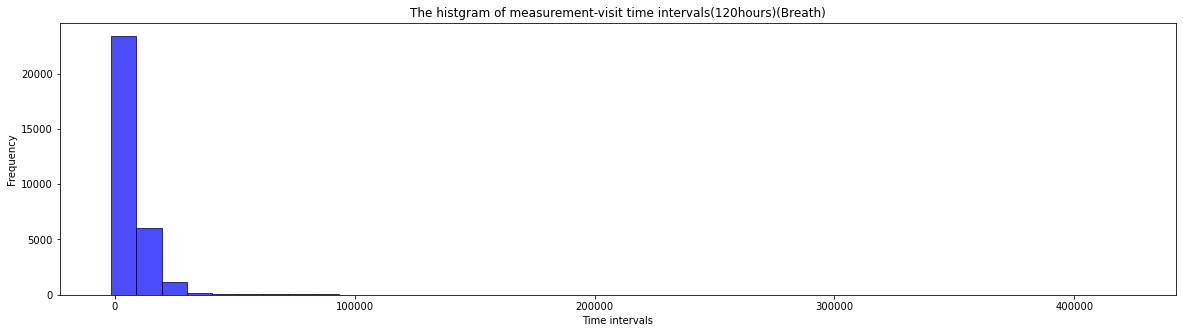

In [13]:
plt.figure(figsize=(20,5))
plt.hist(ti_breath_list, bins=40, facecolor="blue", edgecolor="black", alpha=0.7)
plt.xlabel("Time intervals")
plt.ylabel("Frequency")
plt.title("The histgram of measurement-visit time intervals({}hours)(Breath)".format(T_LENGTH))
plt.savefig(os.path.join(OUTPUT_PATH_V1, 'The histgram of measurement-visit time intervals({}hours)(Breath).png'.format(T_LENGTH)), bbox_inches='tight')
plt.show()

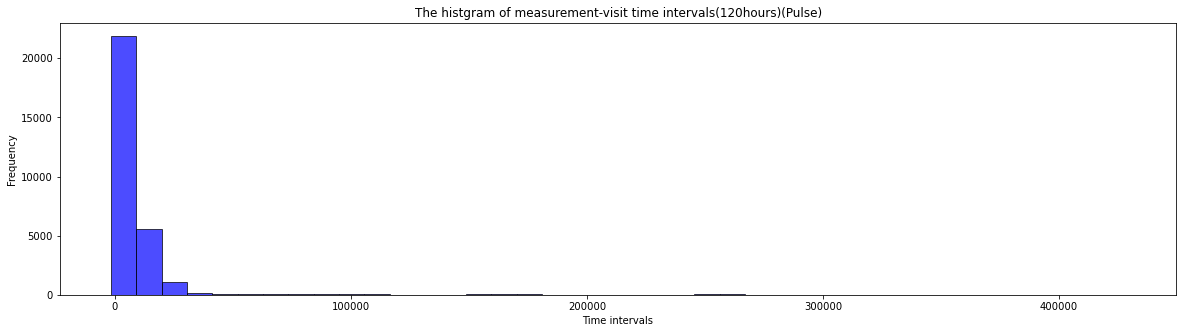

In [14]:
plt.figure(figsize=(20,5))
plt.hist(ti_pulse_list, bins=40, facecolor="blue", edgecolor="black", alpha=0.7)
plt.xlabel("Time intervals")
plt.ylabel("Frequency")
plt.title("The histgram of measurement-visit time intervals({}hours)(Pulse)".format(T_LENGTH))
plt.savefig(os.path.join(OUTPUT_PATH_V1, 'The histgram of measurement-visit time intervals({}hours)(Pulse).png'.format(T_LENGTH)), bbox_inches='tight')
plt.show()

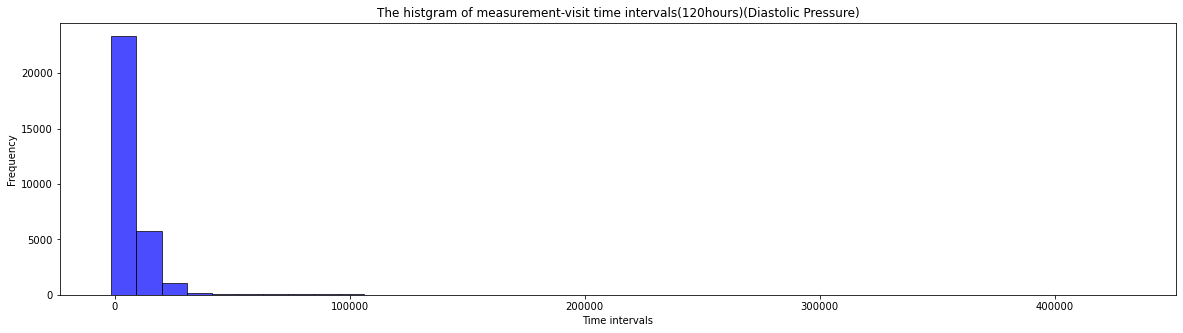

In [15]:
plt.figure(figsize=(20,5))
plt.hist(ti_dia_pressure_list, bins=40, facecolor="blue", edgecolor="black", alpha=0.7)
plt.xlabel("Time intervals")
plt.ylabel("Frequency")
plt.title("The histgram of measurement-visit time intervals({}hours)(Diastolic Pressure)".format(T_LENGTH))
plt.savefig(os.path.join(OUTPUT_PATH_V1, 'The histgram of measurement-visit time intervals({}hours)(Diastolic Pressure).png'.format(T_LENGTH)), bbox_inches='tight')
plt.show()

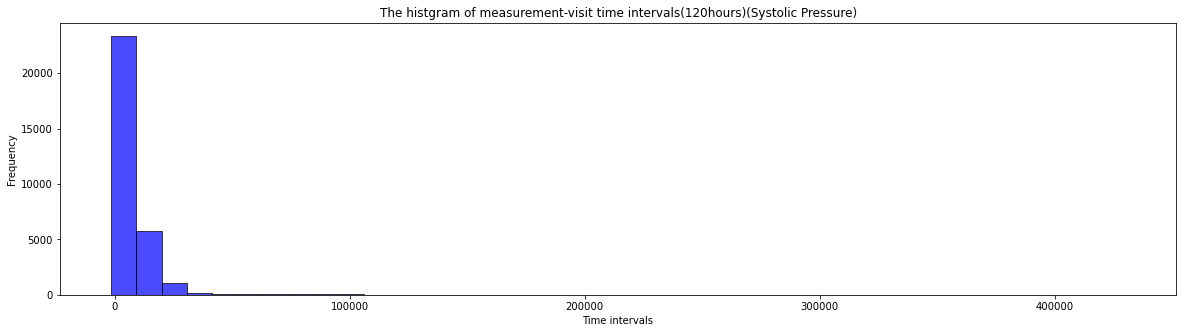

In [16]:
plt.figure(figsize=(20,5))
plt.hist(ti_sys_pressure_list, bins=40, facecolor="blue", edgecolor="black", alpha=0.7)
plt.xlabel("Time intervals")
plt.ylabel("Frequency")
plt.title("The histgram of measurement-visit time intervals({}hours)(Systolic Pressure)".format(T_LENGTH))
plt.savefig(os.path.join(OUTPUT_PATH_V1, 'The histgram of measurement-visit time intervals({}hours)(Systolic Pressure).png'.format(T_LENGTH)), bbox_inches='tight')
plt.show()

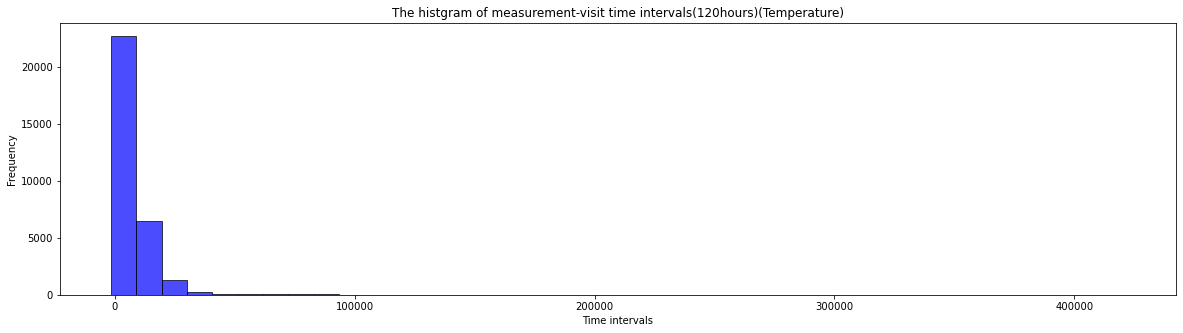

In [17]:
plt.figure(figsize=(20,5))
plt.hist(ti_temperature_list, bins=40, facecolor="blue", edgecolor="black", alpha=0.7)
plt.xlabel("Time intervals")
plt.ylabel("Frequency")
plt.title("The histgram of measurement-visit time intervals({}hours)(Temperature)".format(T_LENGTH))
plt.savefig(os.path.join(OUTPUT_PATH_V1, 'The histgram of measurement-visit time intervals({}hours)(Temperature).png'.format(T_LENGTH)), bbox_inches='tight')
plt.show()

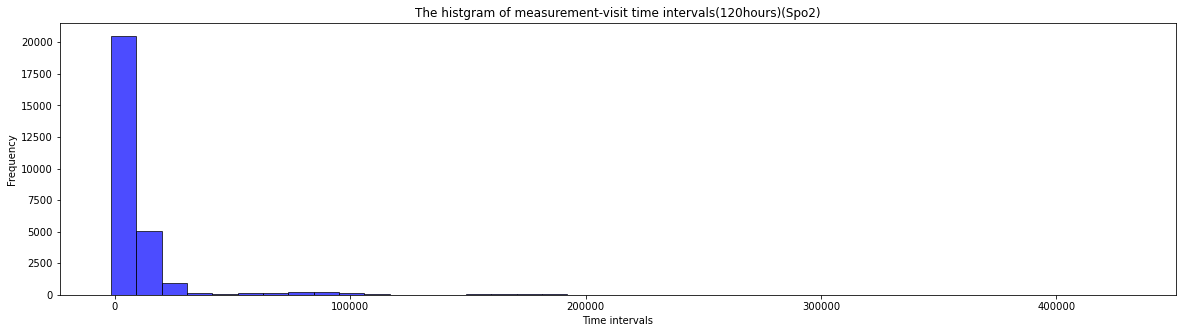

In [18]:
plt.figure(figsize=(20,5))
plt.hist(ti_spo2_list, bins=40, facecolor="blue", edgecolor="black", alpha=0.7)
plt.xlabel("Time intervals")
plt.ylabel("Frequency")
plt.title("The histgram of measurement-visit time intervals({}hours)(Spo2)".format(T_LENGTH))
plt.savefig(os.path.join(OUTPUT_PATH_V1, 'The histgram of measurement-visit time intervals({}hours)(Spo2).png'.format(T_LENGTH)), bbox_inches='tight')
plt.show()

### 7-process the time-series data one by one
- read the time-series data from table P1_SIGN_48H, and produce N files, of which the form is :
- {'timeseries':{'timestep':, 'features':, codes':[(timestamp_index, tsitem_id, value),(),...]}}
- Caution：原先此处有一个value>0的条件，但是执行就报错DatabaseError: ORA-01722: Ungültige Zahl
- [Caution!]: The number of visit with time-series data is 31168

In [19]:
# Create the dict of time-series variables 
map_tsitem_index = {'体温': 0, '呼吸': 1, '脉搏': 2, '舒张压': 3, '收缩压': 4, 'SPO2': 5}
# if  i drop the variables with high missing rate(i.e. SPO2 and pressure), Then:
# map_tsitem_index = {'体温': 0, '呼吸': 1, '脉搏': 2}

In [20]:
def processing_sign(vid, visittime, db_conn, f):

    # the columns type will be filtered
    sql = '''
            select to_date(mea_time, 'YYYY-MM-DD HH24:MI:SS') as mea_time, type, value 
                from p1_sign_{0}h 
                where visit_record_id_new_1 = '{1}'
    '''.format(T_LENGTH, vid)
    signevents = db_conn.conn.execute(sql).fetchall()
    if signevents is None:
        return None
    signevents_wholedata = []
    for se in signevents:
        starttime, type, value = se[0], se[1], float(se[2])
        # dicard values with no starttime
        if starttime is None:
            print('no starttime: ', se, file=f)
            continue
        # discard values with no value
        if value is None:
            print('no value: ', se, file=f)
            continue
        
        # get the time gap with date zero
        startdate = starttime.date()
        date_zero = datetime.datetime.now().replace(year=startdate.year, month=startdate.month,
                                                 day=startdate.day, hour=0, minute=0, second=0)
        date_zero_gap = int((starttime - date_zero).total_seconds())

        signevents_wholedata.append([(starttime - visittime).total_seconds(), date_zero_gap, [starttime, type, value]])
    return signevents_wholedata
# processing_sign('ZY_03261402_1', datetime.datetime.now(), db_connection('fuo'), sys.stdout)


In [21]:
# integrate the time series array for a single visit
def processing(vid, f):
    
    db_conn = db_connection('fuo')
    visit = db_conn.conn.execute("select min(visit_start_date) from visit_zy where visit_record_id_new_1='{0}'".format(vid)).fetchall()
    if visit is None:
        return None
    visittime = visit[0][0]
    if visittime is None:
        return None

    wholedata = []
    wholedata.append(processing_sign(vid, visittime, db_conn, f))
    # here is the sparse matrix, order by timestamp
    wholedata = sorted(list(itertools.chain(*wholedata)), key=itemgetter(0))

    # if i drop the variables with high missing rate(i.e. SPO2 and pressure), Then:
    # D = 3 + 3
    # else:
    D = 6 + 3 # 6 represent the time-series variables, 3 represent the other dimensions, D-1=vid, D-2= starttime-visittime, D-3= starttime-zerotime
    # map time to row
    map_time_index = {}
    index = 0
    for wd in wholedata:
        if (wd[0] not in map_time_index):
            map_time_index[wd[0]] = index
            index += 1
    # create the empty matrix
    patient = [[None for i in range(D)] for j in range(len(map_time_index))]
    numtodivide = [[0 for i in range(D-3)] for j in range(len(map_time_index))]

    for wd in wholedata:
        assert patient[map_time_index[wd[0]]][D-2] == None or patient[map_time_index[wd[0]]][D-2] == wd[0]
        patient[map_time_index[wd[0]]][D-3] = wd[1]
        patient[map_time_index[wd[0]]][D-2] = wd[0]
        patient[map_time_index[wd[0]]][D-1] = vid

        if (patient[map_time_index[wd[0]]][map_tsitem_index[wd[2][1]]] == None):
            patient[map_time_index[wd[0]]][map_tsitem_index[wd[2][1]]] = wd[2][2]
            numtodivide[map_time_index[wd[0]]][map_tsitem_index[wd[2][1]]] = 1
        else:
            patient[map_time_index[wd[0]]][map_tsitem_index[wd[2][1]]] += wd[2][2]
            numtodivide[map_time_index[wd[0]]][map_tsitem_index[wd[2][1]]] += 1

    for i in range(len(map_time_index)):
        for j in range(D-3):
            if (numtodivide[i][j] == 0):
                continue
            try:
                patient[i][j] /= numtodivide[i][j]
            except:
                print('div error: ', i, j, file=f)

    db_conn.conn.close()
    return patient
# processing('ZY_03261402_1', sys.stdout)

In [22]:
def process_visit(vid):
    with open(os.path.join(WORKING_PATH_V1, 'vsdata/log/vs-{0}.log'.format(str(vid))), 'w') as f:
        try:
            proc = processing(vid, f)
            if len(proc) == 0:
                return
            res = {
                'timeseries': sparsify(proc)
            }
            np.save(os.path.join(WORKING_PATH_V1, 'vsdata/vs-{0}.npy'.format(vid)), res)

        except Exception as e:
            with open(os.path.join(WORKING_PATH_V1, 'vsdata/log/vserror-{0}.log'.format(str(vid))), 'w') as ferr:
                traceback.print_exc(file=ferr)
            traceback.print_exc(sys.stdout)
            print('failed at {0}!'.format(vid))


In [23]:
def process_visit_list(vid_list):
    for vid in tqdm(vid_list):
        process_visit(vid)

In [24]:
if not os.path.exists(os.path.join(WORKING_PATH_V1,'vsdata/log')):
    os.makedirs(os.path.join(WORKING_PATH_V1, 'vsdata/log'))
# read the list of visit_record_id_new_1
visit_ids = np.load(os.path.join(WORKING_PATH_V1, 'visit_ids.npy'), allow_pickle=True).tolist()
visit_ids = visit_ids['visit_ids']
# execute the process
# num_workers = cpu_count() // 2
num_workers = 8
p = Pool(num_workers)
for vid_list in np.array_split(visit_ids, num_workers):
    p.apply_async(process_visit_list, args=(vid_list,))
p.close()
p.join()

### 8-process the label data
- read the label data from table LABEL4VISIT
- label1 = '0' : 感染性
- label1 = '1' : 非感染性
- label2 = '0' : 细菌性感染
- label2 = '1' : 病毒性感染
- label2 = '2' : 真菌性感染
- label3 = '0' : NIID类
- label3 = '1' : 肿瘤性疾病
- label4 = '0' : 自身免疫性疾病
- label4 = '1' : 自身炎症性疾病
- label5 = '0' : 血液系统恶性疾病
- label5 = '1' : 实体恶性肿瘤
- [Caution!]: The number of visit with filtered label is 29966

In [25]:
# The visit_ids list after excluded visit age < 15
visit_ids = np.load(os.path.join(WORKING_PATH_V1, 'visit_ids.npy'), allow_pickle=True).tolist()
visit_ids = visit_ids['visit_ids']
visit_ids = pd.DataFrame(visit_ids, columns=['visit_id'])

# read the label table
sql = '''
        select visit_record_id_new_1, 
               label_all,
               label1,
               label2,
               label3,
               label4,
               label5
            from label_v2 where flag_visit='1'
'''
db_conn = db_connection('fuo')
label = db_conn.conn.execute(sql).fetchall()
label = pd.DataFrame(label, columns=['visit_record_id_new_1', 'label_all', 'label1','label2','label3','label4','label5'])
print('[statistics] The shape of original label data is {}'.format(label.shape))

# take the label with visit after excluding the age < 15
label = label.merge(visit_ids, how='inner', left_on='visit_record_id_new_1', right_on='visit_id')
label = label.iloc[:, :7]
print('[statistics] The shape of label data after merged with visit is {}'.format(label.shape))

# output the distribution of label
label_stat = label.groupby('label_all').count().reset_index()
for index, value in label_stat.iterrows():
        print((value['label_all'], value['visit_record_id_new_1']))

# filter the label
label = label.loc[label['label_all'].isin(['1-1','1-2','1-3','2-1-1','2-1-2','2-2-1','2-2-2']), ]
label.sort_values(by=['visit_record_id_new_1'], ascending=True, inplace=True)
label.drop_duplicates(subset=['visit_record_id_new_1', 'label_all'], keep='first', inplace=True)
label.reset_index(inplace=True)
label.drop(columns=['index'], inplace=True)
print('[statistics] The shape of processed label data is {}'.format(label.shape))
print("[statistics] The distribution of label of YL1 is {}".format(label['label1'].value_counts().sort_index().values))
print("[statistics] The distribution of label of YL2-1 is {}".format(label['label2'].value_counts().sort_index().values))
print("[statistics] The distribution of label of YL2-2 is {}".format(label['label3'].value_counts().sort_index().values))
print("[statistics] The distribution of label of YL3-1 is {}".format(label['label4'].value_counts().sort_index().values))
print("[statistics] The distribution of label of YL3-2 is {}".format(label['label5'].value_counts().sort_index().values))

# save the visit_id in label data
visit_ids_valid = label['visit_record_id_new_1'].values.tolist()
if not os.path.exists(WORKING_PATH_V1):
        os.makedirs(WORKING_PATH_V1)
tosave = {'visit_ids_valid': visit_ids_valid}
np.save(os.path.join(WORKING_PATH_V1, 'visit_ids_valid.npy'), tosave)
# save the label dataframe
with open(os.path.join(WORKING_PATH_V1, 'label.pickle'), 'wb') as f:
            pickle.dump(label, f, -1)
db_conn.conn.close()

[statistics] The shape of original label data is (33636, 7)
[statistics] The shape of label data after merged with visit is (33063, 7)
('1', 35)
('1-1', 12158)
('1-2', 4064)
('1-3', 1017)
('2-1-1', 1783)
('2-1-2', 785)
('2-2', 22)
('2-2-1', 1674)
('2-2-2', 1811)
('2-2-3', 217)
('2-3', 43)
('发热待查', 2646)
('合并感染', 167)
('怀孕', 69)
('无出院诊断', 373)
('未知', 5635)
('术后', 564)
[statistics] The shape of processed label data is (23292, 7)
[statistics] The distribution of label of YL1 is [17239  6053]
[statistics] The distribution of label of YL2-1 is [12158  4064  1017]
[statistics] The distribution of label of YL2-2 is [2568 3485]
[statistics] The distribution of label of YL3-1 is [1783  785]
[statistics] The distribution of label of YL3-2 is [1674 1811]


### 9-Merge all the static feature, time-series feature and label data
- one file for data of each visit_record_id_new_1 in visit_ids_valid
- [Cautions!] There are 2091 visit with label, but without p1_sign_48h

In [26]:
def extract_serial_features(vid):
    map_tsitem_index = {'体温': 0, '呼吸': 1, '脉搏': 2, '舒张压': 3, '收缩压': 4, 'SPO2': 5}
    # map_tsitem_index = {'体温': 0, '呼吸': 1, '脉搏': 2}
    tsdata = np.load(os.path.join(WORKING_PATH_V1,'vsdata/vs-{}.npy'.format(vid)), allow_pickle=True).tolist()

    timeseries = tsdata['timeseries']['codes']
    D = tsdata['timeseries']['features']
    assert timeseries[-1][2] == vid
    # get the codes without vid and time-interval seconds
    new_timeseries = []
    for featurename, featureid in map_tsitem_index.items():
        # each temp list represent many tuples of each feature
        temp = []
        for record in timeseries:
            i, j, value = record[0], record[1], record[2]
            if j == featureid:
                temp.append((i, j, value))      
        if temp is not None and len(temp) > 0:
            # len(new_timeseries) = len(map_tsitem_index)
            new_timeseries.append(temp)
    
    # get the timestamps in form of (timestamps, 5, seconds)
    timecolid = len(map_tsitem_index)
    # get the max timestamps (index)
    valid_timestamps = list(itertools.chain(*[[t[0] for t in tt] for tt in new_timeseries]))
    max_timestamp = max(valid_timestamps)
    # get the time gap between sign_time and time_zero
    gap_zero = [(t[0], timecolid, t[2]) for t in timeseries if t[0] <= max_timestamp and t[1] == D - 3]
    new_timeseries.append(gap_zero)
    # get the original timestamps with seconds
    timestamps = [(t[0], timecolid + 1, t[2]) for t in timeseries if t[0] <= max_timestamp and t[1] == D - 2]
    new_timeseries.append(timestamps)
    timelength = max([t[2] for t in timestamps]) - min([t[2] for t in timestamps])

    # get vid
    vidcolid = timecolid + 2
    vids = [(t[0], vidcolid, t[2]) for t in timeseries if t[0] <= max_timestamp and t[1] == D - 1]
    new_timeseries.append(vids)

    # up to here, the len of new_timeseries = 7
    res2 = list(itertools.chain(*new_timeseries))
    return {'timestep': max_timestamp + 1, 'features': vidcolid + 1, 'codes': res2, 'timelength': timelength}

def extract_static_features(vid):
    
    # read the pickle file
    f = open(os.path.join(WORKING_PATH_V1, 'features_stat.pickle'), 'rb')
    (data_val, data_cat) = pickle.load(f)

    data_val_vid = tuple(data_val.loc[data_val['visit_record_id_new_1'] == vid, :].values[0])[1:]
    data_cat_vid = tuple(data_cat.loc[data_cat['visit_record_id_new_1'] == vid, :].values[0])[1:]

    return {'static_features_val': data_val_vid, 'static_features_cat': data_cat_vid}

def extract_labels(vid):

    f = open(os.path.join(WORKING_PATH_V1, 'label.pickle'), 'rb')
    label = pickle.load(f)
    label = label.where(label.notnull(), '')

    return tuple(label.loc[label['visit_record_id_new_1'] == vid, :].values[0])[1:]

# extract_serial_features('ZY_2000061720_1')
# extract_static_features('ZY_2000061720_1')
# extract_labels('ZY_2000061720_1')


In [27]:
def data_merge(vid):
    
    res = {
        'serial_features': extract_serial_features(vid),
        'static_features': extract_static_features(vid),
        'labels': extract_labels(vid)
    }
    np.save(os.path.join(WORKING_PATH_V1, 'alldata/all-{}.npy'.format(vid)), res)

In [28]:
if not os.path.exists(os.path.join(WORKING_PATH_V1, 'alldata/')):
    os.makedirs(os.path.join(WORKING_PATH_V1, 'alldata/'))
# Read the valid visit_ids
if T_LENGTH == 48:
    valid_vids_with_sign = [re.match(r'vs\-(ZY\_\d+\_\d+)\.npy', x) for x in os.listdir(os.path.join(WORKING_PATH_V1, 'vsdata/'))]
else:
    valid_vids_with_sign = [re.match(r'vs\-(ZY\_\d+\_\d+)\.npy', x) for x in os.listdir(os.path.join(WORKING_PATH, '48hours', 'vsdata/'))]

valid_vids_with_sign = sorted([str(x.group(1)) for x in valid_vids_with_sign if x is not None])
valid_vids_with_label = np.load(os.path.join(WORKING_PATH_V1, 'visit_ids_valid.npy'), allow_pickle=True).tolist()['visit_ids_valid']

valid_vids = []
for v in valid_vids_with_label:
    if (v in valid_vids_with_sign):
        valid_vids.append(v)
    else:
        continue
print("[Statistics]: The number of final valid visit_ids is {}".format(len(valid_vids)))
print("[Excluded Message] There are {} visits excluded because of missing serial data".format(len(valid_vids_with_label)-len(valid_vids)))
tosave = {'visit_ids': valid_vids}
np.save(os.path.join(WORKING_PATH_V1, 'visit_ids_with_label&sign.npy'), tosave)   # len = 33636

num_workers = 8
p = Pool(num_workers)
for vid in valid_vids:
    p.apply_async(data_merge, args=(vid, ))
p.close()
p.join()

[Statistics]: The number of final valid visit_ids is 21524
[Excluded Message] There are 1768 visits excluded because of missing serial data


### 10-Seperate the data of each person and concat together
- In this step, wo did not delete the visit that timelength < 48 hrs

In [29]:
def extract_time_series(serial_features):

    tn = serial_features['timestep']
    fn = serial_features['features']
    codes = serial_features['codes']
    series = [[None for ft in range(fn)] for tt in range(tn)]
    for tt, ft, value in codes:
        try:
            series[tt][ft] = value
        except:
            print(tt, ft, value, tn, fn)
    return series

def extract_data(vid):

    alldata = np.load(os.path.join(WORKING_PATH_V1, 'alldata/all-{0}.npy'.format(vid)), allow_pickle=True).tolist()

    return (
        extract_time_series(alldata['serial_features']),
        alldata['static_features']['static_features_val'],
        alldata['static_features']['static_features_cat'],
        alldata['labels']

    )

In [30]:
valid_vids = np.load(os.path.join(WORKING_PATH_V1, 'visit_ids_with_label&sign.npy'), allow_pickle=True).tolist()['visit_ids']

num_workers = 8
p = Pool(num_workers)
collec = [p.apply_async(extract_data, args=(vid,)) for vid in valid_vids]
p.close()
p.join()

collec = [x.get() for x in collec]
collec = [x for x in collec if x is not None]

serial_data = [r[0] for r in collec]
static_data_val = [r[1] for r in collec]
static_data_cat = [r[2] for r in collec]
label_data = [r[3] for r in collec]

np.save(os.path.join(WORKING_PATH_V1, 'Serial_feature_{}hrs.npy'.format(T_LENGTH)), serial_data)
np.save(os.path.join(WORKING_PATH_V1, 'Static_feature_val.npy'), static_data_val)
np.save(os.path.join(WORKING_PATH_V1, 'Static_feature_cat.npy'), static_data_cat)
np.save(os.path.join(WORKING_PATH_V1, 'Label.npy'), label_data)

/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


### 12-process the serial data and calculate the X_new and t_new
- in this step, mainly get the X_t, T_t, X_t_mask_deltaT_t, etc
- In this step, wo did not delete the visit that timelength < 48 hrs
- [Caution!] There are visit with only one record of serial data, there is just one timestamp

In [31]:
# create fold to save the processed data
processed_data_path = os.path.join(WORKING_PATH_V1, 'processed')
if not os.path.exists(processed_data_path):
    os.makedirs(processed_data_path)

print("load serial data file!")
serial_data = np.empty([0], dtype=object)
serial_data = np.concatenate((serial_data, np.load(os.path.join(WORKING_PATH_V1, 'Serial_feature_{}hrs.npy'.format(T_LENGTH)), allow_pickle=True)))

print("load static continous data!")
static_data_val = np.load(os.path.join(WORKING_PATH_V1, 'Static_feature_val.npy'), allow_pickle=True)

print("load static category data!")
static_data_cat = np.load(os.path.join(WORKING_PATH_V1, 'Static_feature_cat.npy'), allow_pickle=True)

print("load label data!")
label_data = np.load(os.path.join(WORKING_PATH_V1, 'Label.npy'), allow_pickle=True)

N = len(serial_data)
print('# of samples:', N)

# extract the matrix without vid and time-intervals seconds, 1-D array of time-intervals for each visit
X_raw = np.array([np.array(xx)[:, :-2] for xx in serial_data]) # array([N * array([t * []], dtype=object)])
tsraw = np.array([np.array(xx)[:, -2] for xx in serial_data])
vid_raw =np.array([np.array(xx)[0, -1] for xx in serial_data])
X_raw = np.array([np.array(xx.tolist(), dtype=float) for xx in X_raw]) # array([N * array([t * []], dtype=float)])
tsraw = np.array([np.array(xx.tolist(), dtype=float) for xx in tsraw])

# mapping the vids into index
map_vids_list = {}
index = 0
for i in range(len(vid_raw)):
    if vid_raw[i] not in map_vids_list:
        map_vids_list[vid_raw[i]] = index
        index += 1

# replace None with np.nan
for i_n in range(N):
    if i_n % 20 == 0:
        print('#', end='')
        sys.stdout.flush()
    for i_t in range(len(X_raw[i_n])):
        for i_d in range(len(X_raw[i_n][i_t])):
            if X_raw[i_n][i_t][i_d] is None:
                X_raw[i_n][i_t][i_d] = np.nan

# concatenate all the N matrix into a big matrix, and the number of columns equals 5 here, to calculate the missing ratio of each serial variable
X_raw_all = np.concatenate(X_raw)

# calculate the missing rate of each column
missing_rate = np.sum(np.isnan(X_raw_all), axis=0) * 1.0 / X_raw_all.shape[0]
print("The missing rate of column (体温, 呼吸, 脉搏, 舒张压, 收缩压, SPO2, time_gap_zero) are respectively {}".format(missing_rate.tolist()))
# set the threshold to drop the column
keep_val_idx = missing_rate < 1-5e-4
keep_val_idx_list = np.where(keep_val_idx)
X_raw_all_kept = X_raw_all[:,keep_val_idx]
X_raw_kept = np.array([xx[:, keep_val_idx] for xx in X_raw])

print('Done!')


load serial data file!
load static continous data!
load static category data!
load label data!
# of samples: 21524


/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


##########

/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [32]:
processed_data_path_raw = os.path.join(processed_data_path, 'raw')
if not os.path.exists(processed_data_path_raw):
    os.makedirs(processed_data_path_raw)

print('Get mean and std for tsdata!')
n_serial_var = X_raw_all_kept.shape[1]
tsdata_mean = np.nanmean(X_raw_all_kept, axis=0)
tsdata_std = np.nanstd(X_raw_all_kept, axis=0)

# merge observations within 60 mins
print('Get X_new and t_new!')
merging_mins = 60
X_new = np.empty([N], dtype=object)
t_new = np.empty([N], dtype=object)
for i in range(N):
    if i % 20 == 0:
        print('#', end='')
        sys.stdout.flush()
    tsraw[i] = tsraw[i].flatten()
    t = 0
    X_new[i] = []
    t_new[i] = []
    while t < len(tsraw[i]):
        t1 = t + 1
        while t1 < len(tsraw[i]) and tsraw[i][t1] - tsraw[i][t] <= merging_mins * 60:
            t1 += 1
        X_new[i].append(
            np.nanmean(X_raw_kept[i][t:t1,:], axis=0)
        )
        t_new[i].append(int((tsraw[i][t1-1]+tsraw[i][t])/2))
        t = t1
print('Done!')

print('Get X_t, mask, etc!')
X_t = np.empty([N], dtype=object)       #N*[t*d]
X_t_mask = np.empty([N], dtype=object)  #N*[t*d]
T_t = t_new                             #N*[t]
deltaT_t = np.empty([N], dtype=object)  #N*[t*d]
for i in range(N):
    if i % 20 == 0:
        print('#', end='')
        sys.stdout.flush()
    X_t[i] = np.vstack(X_new[i])
    X_t_mask[i] = 1 - np.isnan(X_t[i]).astype('int8')
    X_t[i][np.isnan(X_t[i])] = 0
    deltaT_t[i] = np.zeros_like(X_t[i], dtype=int)
    deltaT_t[i][0,:] = 0
    for i_t in range(1, len(T_t[i])):
        deltaT_t[i][i_t, :] = T_t[i][i_t] - T_t[i][i_t-1] + (1-X_t_mask[i][i_t-1,:]) * deltaT_t[i][i_t-1,:]
print('Done!')

print('Process the continous and category data!')
static_data_cat[static_data_cat == ''] = '0'
oe = preprocessing.OrdinalEncoder()
static_data_cat = oe.fit_transform(static_data_cat)

static_data_val[static_data_val == ''] = np.nan
static_data_val[static_data_val == '52.0.0'] = 52
static_data_val = static_data_val.astype(float)
print('Done!')

# save the file
np.savez(os.path.join(processed_data_path_raw, 'processed_data_stats.npz'),
         keep_val_idx_list = keep_val_idx_list,
         tsdata_mean = tsdata_mean,
         tsdata_std = tsdata_std,
         N = N, 
         map_vids_list = map_vids_list,
         missing_rate = missing_rate)
np.savez(os.path.join(processed_data_path_raw, 'processed_data.npz'),
         X_t = X_t,
         X_t_mask = X_t_mask,
         T_t = T_t,
         deltaT_t = deltaT_t,
         static_data_val = static_data_val,
         static_data_cat = static_data_cat,
         label_data = label_data)


Get mean and std for tsdata!
Get X_new and t_new!
#######

/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

In [33]:
# Get the imputed data for serial data
HRS = T_LENGTH
hours_list = [(2, HRS), (4, HRS)]
for n_sample_hour, n_full_hour in hours_list:
    processed_data_path_imputed_fb = os.path.join(processed_data_path, 'imputed_fb' + '_' + str(n_full_hour) + '_' + str(n_sample_hour))
    if not os.path.exists(processed_data_path_imputed_fb):
        os.makedirs(processed_data_path_imputed_fb)

    processed_data_path_imputed_mean = os.path.join(processed_data_path, 'imputed_mean' + '_' + str(n_full_hour) + '_' + str(n_sample_hour))
    if not os.path.exists(processed_data_path_imputed_mean):
        os.makedirs(processed_data_path_imputed_mean)

    print("get X_miss, sampled by {0} in {1} hours".format(n_sample_hour, n_full_hour))
    n_time_step = int(n_full_hour / n_sample_hour)

    # get X_miss first from X_raw_all_kept and tsraw, (sampled)
    X_miss = np.empty([N], dtype = object)
    T_miss = np.zeros([N], dtype = int)
    for i_n in range(N):
        if i_n % 20 == 0:
            print('.', end='')
            sys.stdout.flush()
        T_miss[i_n] = math.ceil(
            (tsraw[i_n][-1] - tsraw[i_n][0]) * 1.0 / (60 * 60 * n_sample_hour))
        X_miss[i_n] = np.zeros([T_miss[i_n], n_serial_var], dtype=float)
        for i_t in range(T_miss[i_n]):
            t_idx = np.logical_and(
                (tsraw[i_n]-tsraw[i_n][0]) >= i_t*(60*60*n_sample_hour),
                (tsraw[i_n]-tsraw[i_n][0]) <= (1+i_t) * (60*60*n_sample_hour))
            X_raw_thist = X_raw_kept[i_n][t_idx, :]
            X_miss[i_n][i_t,:] = np.nanmean(X_raw_thist, axis=0)
    print('done!')

    # X_imputed: do forward/backward imputing from X_miss for lab events
    #            do mean imputing for other events
    print('get X_imputed')
    X_imputed_forward_back = deepcopy(X_miss)
    X_imputed_mean = deepcopy(X_miss)
    for i_n in range(N):
        if i_n % 20 == 0:
            print('.',end='')
            sys.stdout.flush()
        i_n_mean = np.nanmean(X_imputed_forward_back[i_n], axis=0)
        for i_t in range(1, T_miss[i_n]):
            for i_d in range(n_serial_var):
                if np.isnan(X_imputed_forward_back[i_n][i_t, i_d]):
                    X_imputed_forward_back[i_n][i_t, i_d] = X_imputed_forward_back[i_n][i_t-1, i_d]
        for i_t in range(T_miss[i_n]-2, -1, -1):
            for i_d in range(n_serial_var):
                if np.isnan(X_imputed_forward_back[i_n][i_t, i_d]):
                    X_imputed_forward_back[i_n][i_t, i_d] = X_imputed_forward_back[i_n][i_t+1, i_d]
        # Here we use mean value of each feature in current time series to impute nans
        for i_t in range(0, T_miss[i_n]):
            for i_d in range(n_serial_var):
                if np.isnan(X_imputed_mean[i_n][i_t, i_d]):
                    X_imputed_mean[i_n][i_t, i_d] = i_n_mean[i_d]
    print('done!')

    # get first # hours, for both data and masking
    print('get ep_tdata_mean')
    ep_tdata_mean = np.zeros([N, n_time_step, n_serial_var], dtype=float)
    ep_tdata_mean_masking = np.zeros_like(ep_tdata_mean, dtype=int)
    for i_n in range(N):
        if i_n % 20 == 0:
            print('.',end='')
            sys.stdout.flush()
        xx_imp_mean = X_imputed_mean[i_n]
        xx_mis = X_miss[i_n]
        tt_min = min(n_time_step, len(xx_imp_mean))
        if tt_min == 0:
            xx_imp_mean = X_imputed_mean[i_n - 1]
            xx_mis = X_miss[i_n - 1]
            tt_min = min(n_time_step, len(xx_imp_mean))
            X_miss[i_n] = X_miss[i_n - 1]
            X_imputed_mean[i_n] = X_imputed_mean[i_n - 1]
        assert tt_min > 0

        ep_tdata_mean[i_n, :tt_min, :] = xx_imp_mean[:tt_min, :]
        ep_tdata_mean[i_n, tt_min:, :] = ep_tdata_mean[i_n, tt_min-1, :][None, :]
        ep_tdata_mean_masking[i_n, :tt_min, :] = (~np.isnan(xx_mis[:tt_min, :])).astype(int)
    print("Done!")

    ep_data_mean = np.reshape(ep_tdata_mean, [N, n_time_step*n_serial_var])
    ep_data_mean_masking = np.reshape(ep_tdata_mean_masking, [N, n_time_step*n_serial_var])

    # get first # hours, for both data and masking
    print('get ep_tdata_forward_back')
    ep_tdata_forward_back = np.zeros([N, n_time_step, n_serial_var], dtype=float)
    ep_tdata_forward_back_masking = np.zeros_like(ep_tdata_forward_back, dtype=int)
    for i_n in range(N):
        if i_n % 20 == 0:
            print('.',end='')
            sys.stdout.flush()
        xx_imp_forward_back = X_imputed_forward_back[i_n]
        xx_mis = X_miss[i_n]
        tt_min = min(n_time_step, len(xx_imp_forward_back))
        if tt_min == 0:
            xx_imp_forward_back = X_imputed_forward_back[i_n - 1]
            xx_mis = X_miss[i_n - 1]
            tt_min = min(n_time_step, len(xx_imp_forward_back))
            X_miss[i_n] = X_miss[i_n - 1]
            X_imputed_forward_back[i_n] = X_imputed_forward_back[i_n - 1]
        assert tt_min > 0

        ep_tdata_forward_back[i_n, :tt_min, :] = xx_imp_forward_back[:tt_min, :]
        ep_tdata_forward_back[i_n, tt_min:, :] = ep_tdata_forward_back[i_n, tt_min-1, :][None, :]
        ep_tdata_forward_back_masking[i_n, :tt_min, :] = (~np.isnan(xx_mis[:tt_min, :])).astype(int)
    print("Done!")

    ep_data_forward_back = np.reshape(ep_tdata_forward_back, [N, n_time_step*n_serial_var])
    ep_data_forward_back_masking = np.reshape(ep_tdata_forward_back_masking, [N, n_time_step*n_serial_var])

    np.savez(os.path.join(processed_data_path_imputed_mean, 'processed_data_imputed_mean' + '_' + str(n_full_hour) + \
                          '_' + str(n_sample_hour) + '.npz'),
         ep_data = ep_data_mean, ep_tdata = ep_tdata_mean,
         ep_data_masking = ep_data_mean_masking, 
         ep_tdata_masking = ep_tdata_mean_masking,
         static_data_val = static_data_val,
         static_data_cat = static_data_cat,
         label_data = label_data)
    np.savez(os.path.join(processed_data_path_imputed_fb, 'processed_data_imputed_forward_back' + '_' + str(n_full_hour) + \
                          '_' + str(n_sample_hour) + '.npz'),
         ep_data = ep_data_forward_back, ep_tdata = ep_tdata_forward_back,
         ep_data_masking = ep_data_forward_back_masking, 
         ep_tdata_masking = ep_tdata_forward_back_masking,
         static_data_val = static_data_val,
         static_data_cat = static_data_cat,
         label_data = label_data)

get X_miss, sampled by 2 in 120 hours
...

/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### 13-seperate the data into K folds
- in this step, mainly generate the index of K folds
- besides, the mean, std of training dataset have been generated based on each fold

In [34]:
def make_splits(x, y, foldk):

    # split the data into K fold
    assert foldk > 2
    idx_trva_list = []
    idx_te_list = []
    skf = StratifiedKFold(n_splits=foldk,random_state=2021, shuffle=True)
    for train_index, test_index in skf.split(x, y):
        idx_trva_list.append(train_index)
        idx_te_list.append(test_index)

    idx_list = np.empty([foldk, 3], dtype=object)
    for i in range(foldk):
        # split into the train, validation and test
        idx_list[i][0] = np.setdiff1d(idx_trva_list[i], idx_te_list[(i + 1) % foldk], True)
        idx_list[i][1] = idx_te_list[(i + 1) % foldk]
        idx_list[i][2] = idx_te_list[i]

    return idx_list

def gen_folds_ids(foldk, fold_file_path, y, x):
    # generate folds based on label sets
    folds_dict = {}
    assert len(y.shape) > 1
    tempy = y[:, 0]
    try:
        folds = make_splits(x, tempy, foldk)
        folds_dict['idx_label'] = folds
    except:
        print('When split the dataset, there is an error raised!')
        folds = None
        folds_dict['idx_label'] = folds

    np.savez(fold_file_path, **folds_dict)  # [5*3]
    return folds_dict

def gen_folds_ids_refined(foldk, folds, sub_label, fold_file_path_refined):

    # refine the idx_label based on the hierarchical structure of labels
    label_levels = sub_label.shape[1] - 1   #5
    idx_ylevel = np.empty([label_levels], dtype=object)
    for i in range(label_levels):
        idx_ylevel[i] = []
        for j, value in enumerate(sub_label[:, i+1]):
            if value != '':
                idx_ylevel[i].append(j)
    
    folds = folds['idx_label']
    # folds_refined = np.empty([foldk, label_levels, 3], dtype=object)  # 5*5*3 => (5folds, 5labels, 3dataset)
    # for i in range(foldk):
    #     for j in range(label_levels):
    #         folds_refined[i][j][0] = np.array([x for x in idx_ylevel[j] if x in folds[i][0]])
    #         folds_refined[i][j][1] = np.array([x for x in idx_ylevel[j] if x in folds[i][1]])
    #         folds_refined[i][j][2] = np.array([x for x in idx_ylevel[j] if x in folds[i][2]])
    
    foldsl = {}
    for i in range(label_levels):
        foldsl['hy-%d'%i] = np.empty([foldk, 3], dtype=object)
        for j in range(foldk):
            foldsl['hy-%d'%i][j][0] = np.array([x for x in idx_ylevel[i] if x in folds[j][0]])
            foldsl['hy-%d'%i][j][1] = np.array([x for x in idx_ylevel[i] if x in folds[j][1]])
            foldsl['hy-%d'%i][j][2] = np.array([x for x in idx_ylevel[i] if x in folds[j][2]])
    
    np.savez(fold_file_path_refined, **foldsl)  #{5*[5*3]}
    return foldsl

def get_stats_of_training_data(training_idx, sub_tsdata, sub_masking, sub_statdata_val):

    trainset_ts = np.concatenate(sub_tsdata[training_idx])
    trainset_ts_masking = np.concatenate(sub_masking[training_idx])
    trainset_nts_val = sub_statdata_val[training_idx]
    id_num = trainset_ts.shape[0]
    dim_ts = trainset_ts.shape[1]
    stats_ts = np.empty((dim_ts, 2)) * np.nan
    for d in range(dim_ts):
        dim_masking = trainset_ts_masking[:, d].flatten()
        dim_values = trainset_ts[:,d].flatten()[np.where(dim_masking == 1)]
        dim_mean = np.nanmean(dim_values)
        dim_std = np.nanstd(dim_values)
        stats_ts[d, :] = np.array([dim_mean, dim_std])

    dim_nts = sub_statdata_val.shape[1]
    stats_nts = np.empty((dim_nts, 2)) * np.nan
    for d in range(dim_nts):
        dim_values = trainset_nts_val[:, d].flatten()
        dim_mean = np.nanmean(dim_values)
        dim_std = np.nanstd(dim_values)
        stats_nts[d, :] = np.array([dim_mean, dim_std])

    return stats_ts, stats_nts

def get_stats_for_folds(foldsl, statsfunc, sub_tsdata, sub_masking, sub_statdata_val, fold_file_path_refined_stats):
    
    statsdict = {}
    for key, value in foldsl.items():
        statsdict[key] = []
        foldsln = value.shape[0] # 5
        for fold in range(foldsln):
            training_idx = value[fold, 0]
            stats_ts, stats_nts = statsfunc(training_idx, sub_tsdata, sub_masking, sub_statdata_val)
            stats_ts_list = [stats_ts[:, 0], stats_ts[:, 1]]
            stats_nts_list = [stats_nts[:, 0], stats_nts[:, 1]]
            
            statsdict[key].append(np.array([stats_ts_list, stats_nts_list]))
    np.savez(fold_file_path_refined_stats, **statsdict)  # {5*[5*2*2]}
    
    return statsdict

def split_dataset(foldk, datasetfilename, tsdata_attr, tsdata_masking_attr, statdata_val_attr, statdata_cat_attr, label_attr, statsfunc, fold_filedir):

    dataset = np.load(os.path.join(fold_filedir, datasetfilename + '.npz'), allow_pickle=True)
    # extract the data
    subdataset = {}
    for key, value in dataset.items():
        subdataset[key] = value
    sub_tsdata = subdataset[tsdata_attr]
    sub_masking = subdataset[tsdata_masking_attr]
    sub_statdata_val = subdataset[statdata_val_attr]
    sub_statdata_cat = subdataset[statdata_cat_attr]
    sub_label = subdataset[label_attr]

    # generate the K folds vid index file
    fold_file_path = os.path.join(fold_filedir, '%d-folds.npz' % foldk)
    folds = gen_folds_ids(foldk=foldk, fold_file_path=fold_file_path, y=sub_label, x=sub_statdata_val)
    # create index for all 5 labels
    fold_file_path_refined = os.path.join(fold_filedir, '%d-folds-refined.npz' % foldk)
    foldsl = gen_folds_ids_refined(foldk, folds, sub_label, fold_file_path_refined)
    # calculate the mean, std according the trainging dataset on each fold
    fold_file_path_refined_stats = os.path.join(fold_filedir, '%d-folds-refined-stdized.npz' % foldk)
    statsdict = get_stats_for_folds(foldsl, statsfunc, sub_tsdata, sub_masking, sub_statdata_val, fold_file_path_refined_stats)

    print('finished!')

In [35]:
# create fold to save the processed data
processed_data_path = os.path.join(WORKING_PATH_V1, 'processed')
if not os.path.exists(processed_data_path):
    os.makedirs(processed_data_path)

In [36]:
print('make splits into K folds!')
foldk = 10
RAWDIR = os.path.join(processed_data_path, 'raw')
IMPUTEDDIR_FB_48_2 = os.path.join(processed_data_path, 'imputed_fb_{}_2'.format(T_LENGTH))
IMPUTEDDIR_FB_48_4 = os.path.join(processed_data_path, 'imputed_fb_{}_4'.format(T_LENGTH))
IMPUTEDDIR_MEAN_48_2 = os.path.join(processed_data_path, 'imputed_mean_{}_2'.format(T_LENGTH))
IMPUTEDDIR_MEAN_48_4 = os.path.join(processed_data_path, 'imputed_mean_{}_4'.format(T_LENGTH))
path_list = [RAWDIR, IMPUTEDDIR_FB_48_2, IMPUTEDDIR_FB_48_4, IMPUTEDDIR_MEAN_48_2, IMPUTEDDIR_MEAN_48_4]

file_list = ['processed_data', 
             'processed_data_imputed_forward_back_{}_2'.format(T_LENGTH), 
             'processed_data_imputed_forward_back_{}_4'.format(T_LENGTH), 
             'processed_data_imputed_mean_{}_2'.format(T_LENGTH), 
             'processed_data_imputed_mean_{}_4'.format(T_LENGTH)]

attr_list = [['X_t', 'X_t_mask'],
             ['ep_tdata', 'ep_tdata_masking'],
             ['ep_tdata', 'ep_tdata_masking'],
             ['ep_tdata', 'ep_tdata_masking'],
             ['ep_tdata', 'ep_tdata_masking']]
fold_file_dirs = os.path.join(WORKING_PATH_V1, 'processed')
for filename, fold_file_dir, attr_name in zip(file_list, path_list, attr_list):
    split_dataset(
        foldk = foldk, 
        datasetfilename = filename,
        tsdata_attr = attr_name[0],
        tsdata_masking_attr = attr_name[1],
        statdata_val_attr = 'static_data_val',
        statdata_cat_attr = 'static_data_cat',
        label_attr = 'label_data',
        statsfunc = get_stats_of_training_data, 
        fold_filedir = fold_file_dir
    )

make splits into K folds!


/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/ipykernel_launcher.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


finished!


/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/ipykernel_launcher.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


finished!


/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/ipykernel_launcher.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


finished!


/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/ipykernel_launcher.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


finished!


/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/ipykernel_launcher.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


finished!


### 14-prepare the data for HC model
- in this step, we extracted the data and get the input files for hierarchical FUO classification model
- This is the first try of input file for the multi-modality HC model

In [37]:
hours = T_LENGTH
for filename, fold_file_dir, attr_name in zip(file_list, path_list, attr_list):

    input_data_path = os.path.join(fold_file_dir, 'data4hc_v20220401')
    if not os.path.exists(input_data_path):
        os.makedirs(input_data_path)
    
    data = np.load(os.path.join(fold_file_dir, filename + '.npz'), allow_pickle=True)
    folds= np.load(os.path.join(fold_file_dir, '%d-folds-refined.npz' % foldk), allow_pickle=True)
    folds_stdized= np.load(os.path.join(fold_file_dir, '%d-folds-refined-stdized.npz' % foldk), allow_pickle=True)
    print("The data files of {0} will be converted and saved here: {1}".format(fold_file_dir, input_data_path))
    
    # convert the processed_data.npz into data.npz
    if filename == 'processed_data':
        timestamp = data['T_t']
        processed_data = {
            'input': data['X_t'],
            'masking': data['X_t_mask'],
            'static_val': data['static_data_val'],
            'static_cat': data['static_data_cat']
        }  

        N = len(timestamp)
        # process input, masking, and timestamp, and keep only the first 48 hours (if the deltaT_t information is not used, which needs to be checked out)
        for i in range(N):
            timestamp[i] = np.asarray(timestamp[i]) - timestamp[i][0]    # ensure the first timestamp is always 0
            l = np.sum(timestamp[i] <= hours * 60 * 60)
            timestamp[i] = timestamp[i][:l]
            for k in processed_data.keys():
                if k == 'input' or k == 'masking':
                    processed_data[k][i] = processed_data[k][i][:l]

        # extract the original label data
        data_label = data['label_data']
        multilabel_mapping = {'1-1':'0', '1-2':'1', '1-3':'2', '2-1-1':'3', '2-1-2':'4', '2-2-1':'5', '2-2-2':'6'}
        for key, value in enumerate(data_label[:,0]):
            data_label[:,0][key] = multilabel_mapping[value]
        processed_label = {
            'label': data_label
        }

        # add the one-hot encoded data for the categorical data 
        ohe = preprocessing.OneHotEncoder()
        processed_data['static_cat_onehot'] = ohe.fit_transform(data['static_data_cat']).toarray()

        # save the file
        np.savez(os.path.join(input_data_path, 'data.npz'), timestamp=timestamp, **processed_data, **processed_label)
    else:
        processed_data = {
            'input': data[attr_name[0]],
            'masking': data[attr_name[1]],
            'static_val': data['static_data_val'],
            'static_cat': data['static_data_cat']
        }
        
        # extract the original label data
        data_label = data['label_data']
        multilabel_mapping = {'1-1':'0', '1-2':'1', '1-3':'2', '2-1-1':'3', '2-1-2':'4', '2-2-1':'5', '2-2-2':'6'}
        for key, value in enumerate(data_label[:,0]):
            data_label[:,0][key] = multilabel_mapping[value]

        processed_label = {
            'label': data_label
        }

        # add the one-hot encoded data for the categorical data
        ohe = preprocessing.OneHotEncoder()
        processed_data['static_cat_onehot'] = ohe.fit_transform(data['static_data_cat']).toarray()
        
        # save the file
        np.savez(os.path.join(input_data_path, 'data.npz'), **processed_data, **processed_label)
    
    # process the fold
    processed_stats = {}
    for k in range(5):
        processed_stats['mean-temporal-{}'.format(str(k))] = folds_stdized['hy-{}'.format(str(k))][:, 0, 0]
        processed_stats['std-temporal-{}'.format(str(k))] = folds_stdized['hy-{}'.format(str(k))][:, 0, 1]
        processed_stats['mean-static-{}'.format(str(k))] = folds_stdized['hy-{}'.format(str(k))][:, 1, 0]
        processed_stats['std-static-{}'.format(str(k))] = folds_stdized['hy-{}'.format(str(k))][:, 1, 1]

    for k in processed_stats:
        processed_stats[k] = np.repeat(processed_stats[k][:, np.newaxis], 3, axis=-1)

    # save the file
    np.savez(os.path.join(input_data_path, 'fold.npz'), **folds, **processed_stats)

    # size check
    data = np.load(os.path.join(input_data_path, 'data.npz'), allow_pickle=True)
    for k in data.keys():
        print(k, data[k].shape)

    fold = np.load(os.path.join(input_data_path, 'fold.npz'), allow_pickle=True)
    for k in fold.keys():
        print(k, fold[k].shape)
        for f in fold[k]:
            print('\t', [x.shape for x in f])


The data files of ./data/phase_viii/120hours/processed/raw will be converted and saved here: ./data/phase_viii/120hours/processed/raw/data4hc_v20220401
timestamp (21524,)
input (21524,)
masking (21524,)
static_val (21524, 137)
static_cat (21524, 53)
static_cat_onehot (21524, 286)
label (21524, 6)
hy-0 (10, 3)
	 [(17218,), (2153,), (2153,)]
	 [(17218,), (2153,), (2153,)]
	 [(17218,), (2153,), (2153,)]
	 [(17219,), (2152,), (2153,)]
	 [(17220,), (2152,), (2152,)]
	 [(17220,), (2152,), (2152,)]
	 [(17220,), (2152,), (2152,)]
	 [(17220,), (2152,), (2152,)]
	 [(17220,), (2152,), (2152,)]
	 [(17219,), (2153,), (2152,)]
hy-1 (10, 3)
	 [(12825,), (1604,), (1604,)]
	 [(12826,), (1603,), (1604,)]
	 [(12827,), (1603,), (1603,)]
	 [(12827,), (1603,), (1603,)]
	 [(12827,), (1603,), (1603,)]
	 [(12827,), (1603,), (1603,)]
	 [(12827,), (1603,), (1603,)]
	 [(12826,), (1604,), (1603,)]
	 [(12826,), (1603,), (1604,)]
	 [(12826,), (1604,), (1603,)]
hy-2 (10, 3)
	 [(4393,), (549,), (549,)]
	 [(4392,), (55

### 15-last check the label distribution
- in this step, we check the distribution of label 

In [38]:
# The visit_ids list after excluded visit age < 15
visit_ids = np.load(os.path.join(WORKING_PATH_V1, 'visit_ids_with_label&sign.npy'), allow_pickle=True).tolist()
visit_ids = visit_ids['visit_ids']
visit_ids = pd.DataFrame(visit_ids, columns=['visit_id'])

# read the label table
sql = '''
        select visit_record_id_new_1, 
               label_all,
               label1,
               label2,
               label3,
               label4,
               label5
            from label_v2 where flag_visit='1'
'''
db_conn = db_connection('fuo')
label = db_conn.conn.execute(sql).fetchall()
label = pd.DataFrame(label, columns=['visit_record_id_new_1', 'label_all', 'label1','label2','label3','label4','label5'])
print('[statistics] The shape of original label data is {}'.format(label.shape))

# take the label with visit after excluding the age < 15
label = label.merge(visit_ids, how='inner', left_on='visit_record_id_new_1', right_on='visit_id')
label = label.iloc[:, :7]
print('[statistics] The shape of label data after merged with visit is {}'.format(label.shape))

# output the distribution of label
label_stat = label.groupby('label_all').count().reset_index()
for index, value in label_stat.iterrows():
        print((value['label_all'], value['visit_record_id_new_1']))

# filter the label
label = label.loc[label['label_all'].isin(['1-1','1-2','1-3','2-1-1','2-1-2','2-2-1','2-2-2']), ]
label.sort_values(by=['visit_record_id_new_1'], ascending=True, inplace=True)
label.drop_duplicates(subset=['visit_record_id_new_1', 'label_all'], keep='first', inplace=True)
label.reset_index(inplace=True)
label.drop(columns=['index'], inplace=True)
print('[statistics] The shape of processed label data is {}'.format(label.shape))
print("[statistics] The distribution of label of YL1 is {}".format(label['label1'].value_counts().sort_index().values))
print("[statistics] The distribution of label of YL2-1 is {}".format(label['label2'].value_counts().sort_index().values))
print("[statistics] The distribution of label of YL2-2 is {}".format(label['label3'].value_counts().sort_index().values))
print("[statistics] The distribution of label of YL3-1 is {}".format(label['label4'].value_counts().sort_index().values))
print("[statistics] The distribution of label of YL3-2 is {}".format(label['label5'].value_counts().sort_index().values))

db_conn.conn.close()

[statistics] The shape of original label data is (33636, 7)
[statistics] The shape of label data after merged with visit is (21524, 7)
('1-1', 11235)
('1-2', 3827)
('1-3', 971)
('2-1-1', 1604)
('2-1-2', 711)
('2-2-1', 1515)
('2-2-2', 1661)
[statistics] The shape of processed label data is (21524, 7)
[statistics] The distribution of label of YL1 is [16033  5491]
[statistics] The distribution of label of YL2-1 is [11235  3827   971]
[statistics] The distribution of label of YL2-2 is [2315 3176]
[statistics] The distribution of label of YL3-1 is [1604  711]
[statistics] The distribution of label of YL3-2 is [1515 1661]


### 16-Recheck the sample frequencey of time-series data in complete range of visit
- x-axis represent the number of sample data point after admission
- y-axis represent the number of visit

In [39]:
db_conn = db_connection('fuo')
dist_data = db_conn.conn.execute('select visit_record_id_new_1, type, count(1) from signs group by visit_record_id_new_1, type').fetchall()
breath, pulse, pressure, temperature, spo2 = {}, {}, {}, {}, {}
for i in dist_data:
    if i[1] == '呼吸':
        breath[i[0]] = i[2]
    elif i[1] == '脉搏':
        pulse[i[0]] = i[2]
    elif i[1] == '血压':
        pressure[i[0]] = i[2]
    elif i[1] == '体温':
        temperature[i[0]] = i[2]
    elif i[1] == 'SPO2':
        spo2[i[0]] = i[2]

breath_count, pulse_count, pressure_count, temperature_count, spo2_count = {}, {}, {}, {}, {}
for key, value in breath.items():
    if value not in breath_count.keys():
        breath_count[value] = 1
    else:
        breath_count[value] = breath_count[value] + 1

for key, value in pulse.items():
    if value not in pulse_count.keys():
        pulse_count[value] = 1
    else:
        pulse_count[value] = pulse_count[value] + 1

for key, value in pressure.items():
    if value not in pressure_count.keys():
        pressure_count[value] = 1
    else:
        pressure_count[value] = pressure_count[value] + 1

for key, value in temperature.items():
    if value not in temperature_count.keys():
        temperature_count[value] = 1
    else:
        temperature_count[value] = temperature_count[value] + 1

for key, value in spo2.items():
    if value not in spo2_count.keys():
        spo2_count[value] = 1
    else:
        spo2_count[value] = spo2_count[value] + 1

df_breath = pd.DataFrame.from_dict(breath_count, orient='index',columns=['counts'])
df_breath = df_breath.reset_index().rename(columns = {'index':'id'})
df_breath.sort_values(by=['id'], inplace=True, ascending=True)

df_pulse = pd.DataFrame.from_dict(pulse_count, orient='index',columns=['counts'])
df_pulse = df_pulse.reset_index().rename(columns = {'index':'id'})
df_pulse.sort_values(by=['id'], inplace=True, ascending=True)

df_pressure = pd.DataFrame.from_dict(pressure_count, orient='index',columns=['counts'])
df_pressure = df_pressure.reset_index().rename(columns = {'index':'id'})
df_pressure.sort_values(by=['id'], inplace=True, ascending=True)

df_temperature = pd.DataFrame.from_dict(temperature_count, orient='index',columns=['counts'])
df_temperature = df_temperature.reset_index().rename(columns = {'index':'id'})
df_temperature.sort_values(by=['id'], inplace=True, ascending=True)

df_spo2 = pd.DataFrame.from_dict(spo2_count, orient='index',columns=['counts'])
df_spo2 = df_spo2.reset_index().rename(columns = {'index':'id'})
df_spo2.sort_values(by=['id'], inplace=True, ascending=True)

db_conn.conn.close()

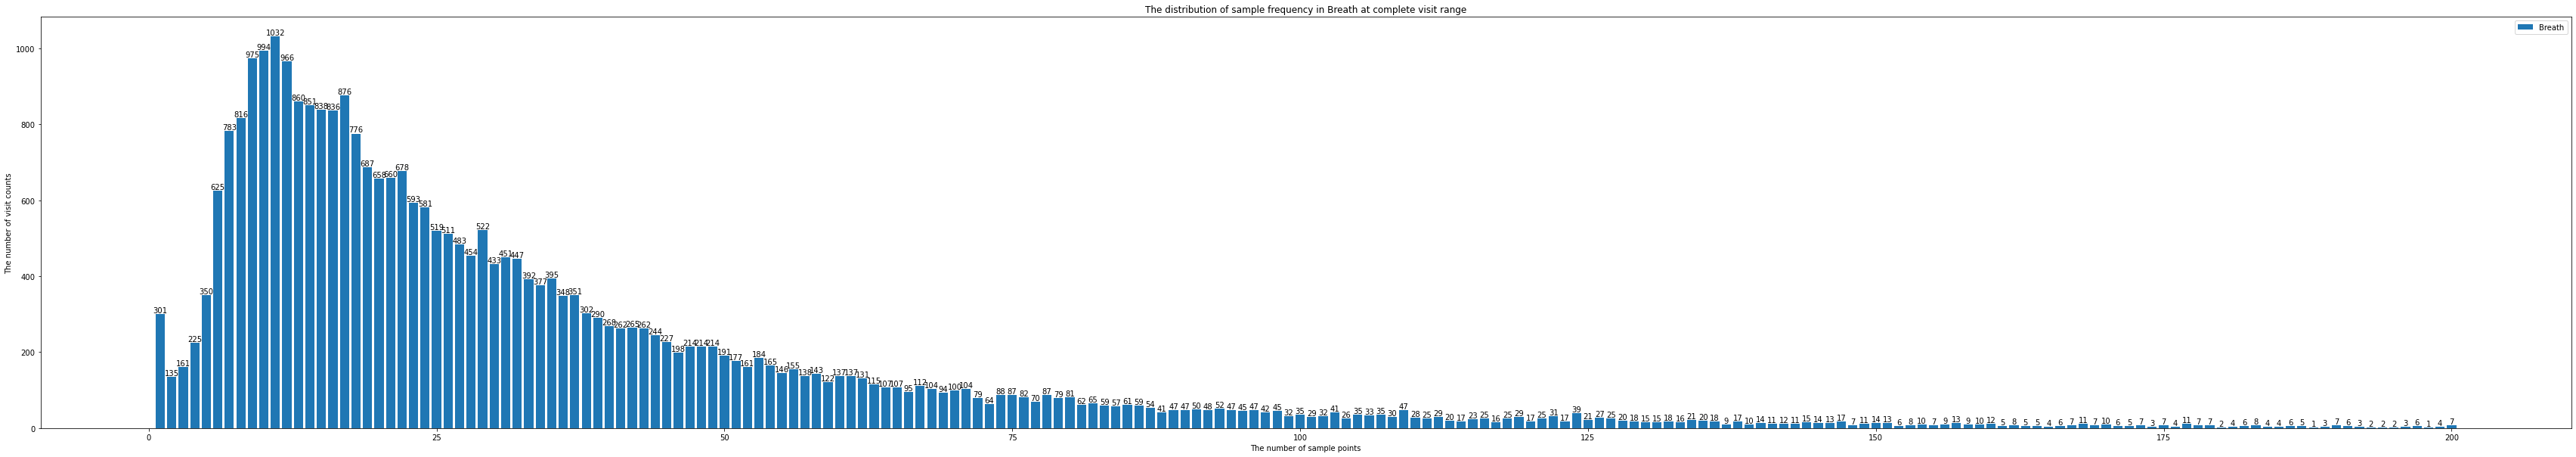

In [40]:
plt.figure(figsize=(60,10))
p1 = plt.bar(df_breath['id'][:200], df_breath['counts'][:200], label='Breath')
for a, b in zip(df_breath['id'][:200], df_breath['counts'][:200]):
    plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=10)
plt.title('The distribution of sample frequency in Breath at complete visit range')
plt.xlabel('The number of sample points')
plt.ylabel('The number of visit counts')
plt.legend()
plt.savefig(os.path.join(OUTPUT_PATH, 'Distribution_of_sample_frequency(Breath)(Complete Visit).png'), bbox_inches='tight')
plt.show()

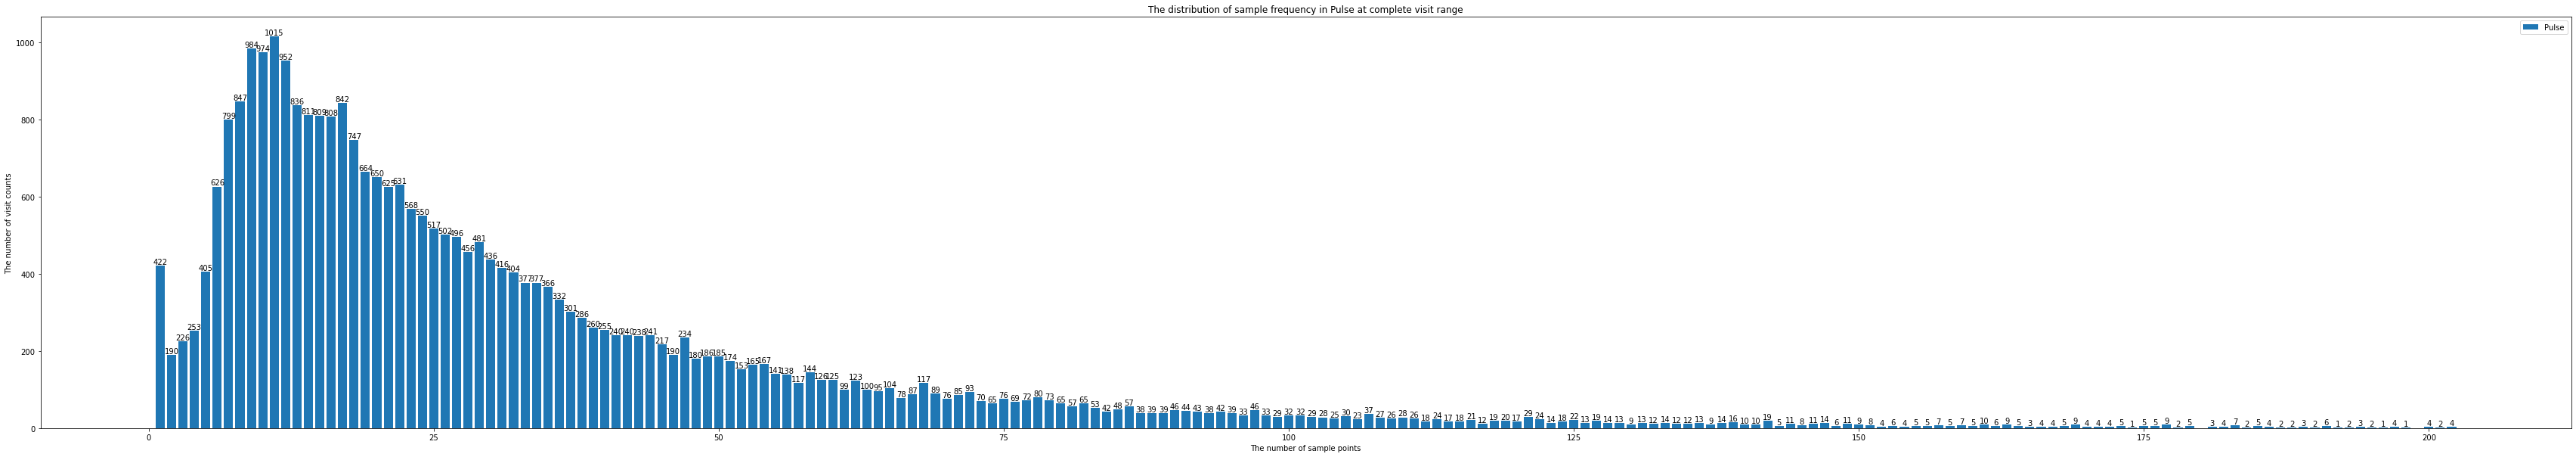

In [41]:
plt.figure(figsize=(60,10))
p1 = plt.bar(df_pulse['id'][:200], df_pulse['counts'][:200], label='Pulse')
for a, b in zip(df_pulse['id'][:200], df_pulse['counts'][:200]):
    plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=10)
plt.title('The distribution of sample frequency in Pulse at complete visit range')
plt.xlabel('The number of sample points')
plt.ylabel('The number of visit counts')
plt.legend()
plt.savefig(os.path.join(OUTPUT_PATH, 'Distribution_of_sample_frequency(Pulse)(Complete Visit).png'), bbox_inches='tight')
plt.show()

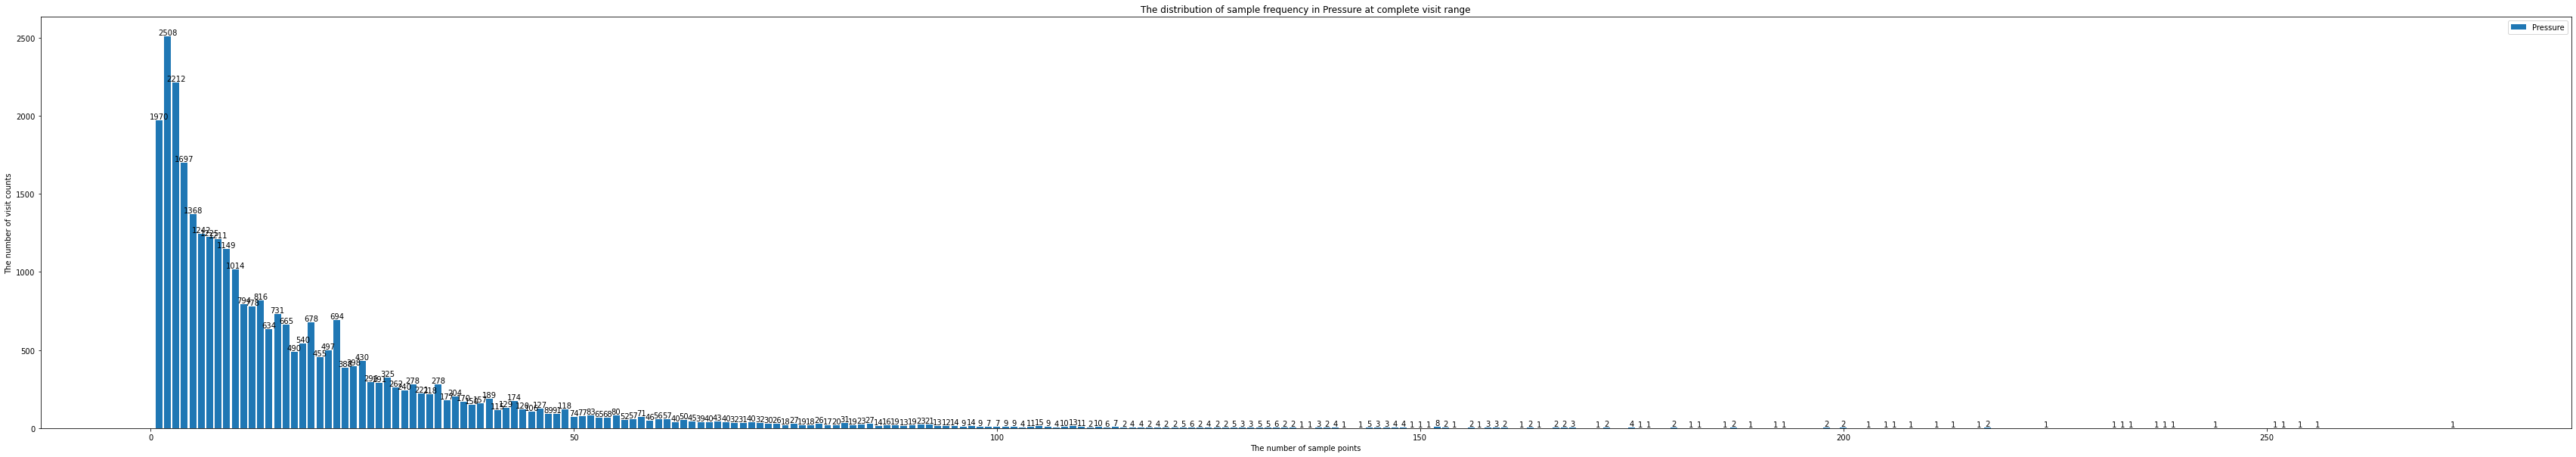

In [42]:
plt.figure(figsize=(60,10))
p1 = plt.bar(df_pressure['id'][:200], df_pressure['counts'][:200], label='Pressure')
for a, b in zip(df_pressure['id'][:200], df_pressure['counts'][:200]):
    plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=10)
plt.title('The distribution of sample frequency in Pressure at complete visit range')
plt.xlabel('The number of sample points')
plt.ylabel('The number of visit counts')
plt.legend()
plt.savefig(os.path.join(OUTPUT_PATH, 'Distribution_of_sample_frequency(Pressure)(Complete Visit).png'), bbox_inches='tight')
plt.show()

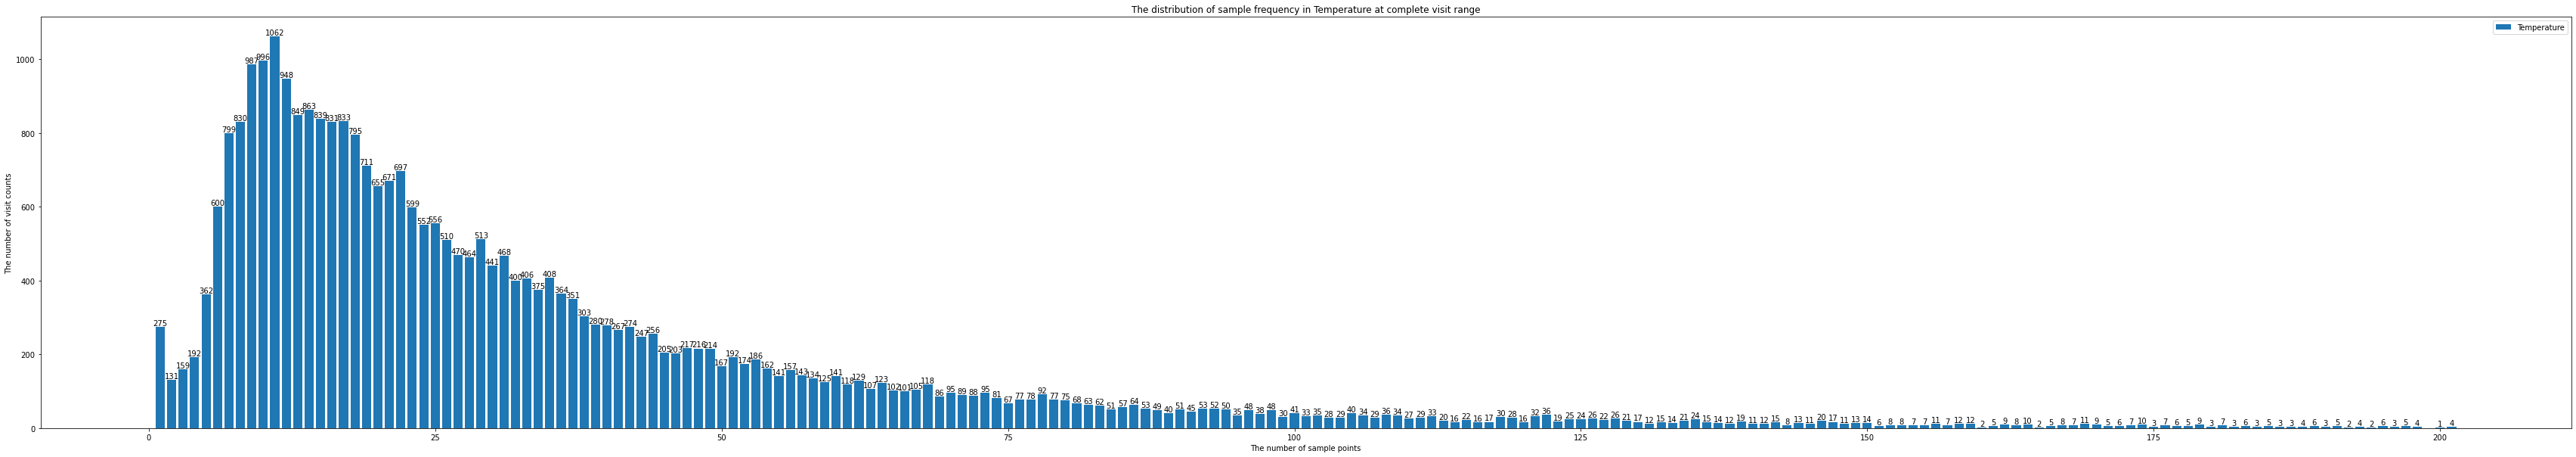

In [43]:
plt.figure(figsize=(60,10))
p1 = plt.bar(df_temperature['id'][:200], df_temperature['counts'][:200], label='Temperature')
for a, b in zip(df_temperature['id'][:200], df_temperature['counts'][:200]):
    plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=10)
plt.title('The distribution of sample frequency in Temperature at complete visit range')
plt.xlabel('The number of sample points')
plt.ylabel('The number of visit counts')
plt.legend()
plt.savefig(os.path.join(OUTPUT_PATH, 'Distribution_of_sample_frequency(Temperature)(Complete Visit).png'), bbox_inches='tight')
plt.show()

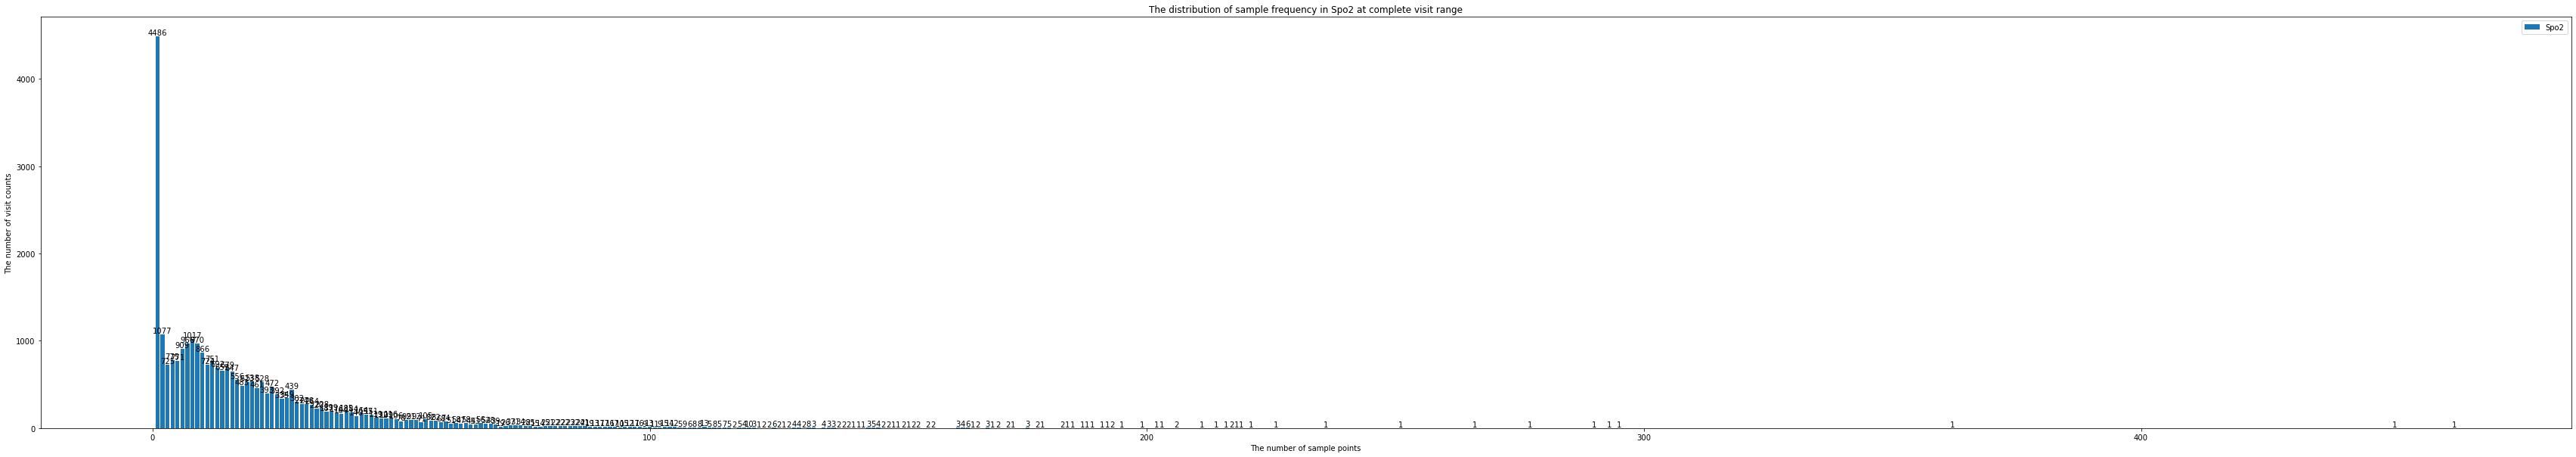

In [44]:
plt.figure(figsize=(60,10))
p1 = plt.bar(df_spo2['id'][:200], df_spo2['counts'][:200], label='Spo2')
for a, b in zip(df_spo2['id'][:200], df_spo2['counts'][:200]):
    plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=10)
plt.title('The distribution of sample frequency in Spo2 at complete visit range')
plt.xlabel('The number of sample points')
plt.ylabel('The number of visit counts')
plt.legend()
plt.savefig(os.path.join(OUTPUT_PATH, 'Distribution_of_sample_frequency(Spo2)(Complete Visit).png'), bbox_inches='tight')
plt.show()